# 7506 - Trabajo práctico 1


##### Librerías

In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
import scipy.stats as st
import scipy as sc
from sklearn.ensemble import IsolationForest
import sklearn as sk
import geopandas as gpd

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
from IPython.display import display, HTML


def display_side_by_side(dfs: list, captions: list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [4]:
complete_dataset = pd.read_csv("./properati_argentina_2021.csv")
df = complete_dataset.copy()

## Análisis Exploratorio y Preprocesamiento de Datos

Primero, observaremos un poco los datos que tiene el dataset

**Primeras 5 observaciones**

In [5]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


**Ultimas 5 observaciones**

In [6]:
df.tail()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
460149,EWHC/xcODFkeEA0+pPE6Rw==,2021-01-05,2021-01-08,2021-01-05,-34.599594,-58.588715,Bs.As. G.B.A. Zona Oeste,Tres de Febrero,NaN,NaN,NaN,Venta,Local comercial,NaN,NaN,113.0,113.0,190000.0,USD,LOCAL COMERCIAL MAS DE 100 MTS. - Ciudad jardín-
460150,txKUq0LjMaORjJQeeqTOfw==,2021-01-05,2021-11-01,2021-01-05,-34.582777,-58.545220,Bs.As. G.B.A. Zona Norte,General San Martín,Villa Lynch,NaN,NaN,Venta,Local comercial,NaN,NaN,11580.0,11580.0,3500000.0,USD,Nave Industrial - Villa Lynch
460151,E0zwHT18DX8AxhU22hXgng==,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,Venta,Local comercial,NaN,NaN,915.0,915.0,800000.0,USD,importante edificio comercial en tres plantas ...
460152,Ec4Tvy/WX5f6RgfaJf2FHQ==,2021-01-05,2021-11-28,2021-01-05,-33.226234,-60.331848,Santa Fe,Villa Constitución,NaN,NaN,NaN,Alquiler,Local comercial,NaN,NaN,NaN,15.0,NaN,NaN,Local - Villa Constitucion
460153,Y7KBafQ+e5noGh2Pio0xLg==,2021-01-05,9999-12-31,2021-01-05,-26.827938,-65.220708,Tucumán,San Miguel de Tucumán,NaN,NaN,NaN,Venta,Local comercial,1.0,NaN,243.0,133.0,160000.0,USD,Local - San Miguel De Tucumán


In [7]:
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

El dataset tiene 460154 filas y 20 columnas


In [8]:
df.describe()

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,419740.000000,419740.000000,0.0,368498.000000,344113.000000,397813.000000,4.279160e+05,4.421530e+05
mean,-34.228570,-59.557066,NaN,3.278053,2.297960,420.601250,9.605005e+03,3.063273e+05
std,3.251509,2.905129,NaN,1.870832,1.673985,4026.380748,3.440367e+06,4.899613e+06
min,-54.832057,-103.219258,NaN,1.000000,-3.000000,-1.000000,-3.000000e+00,0.000000e+00
25%,-34.640132,-58.899343,NaN,2.000000,1.000000,50.000000,4.500000e+01,4.490000e+04
50%,-34.585122,-58.488309,NaN,3.000000,2.000000,90.000000,7.800000e+01,9.800000e+04
75%,-34.423414,-58.404876,NaN,4.000000,3.000000,210.000000,1.700000e+02,1.990000e+05
max,42.557773,-35.044991,NaN,40.000000,390.000000,200000.000000,2.147484e+09,1.500000e+09


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

In [10]:
df.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

## Descripción de las columnas
- type - Tipo de aviso (Propiedad, Desarrollo/Proyecto).
- country - País en el que está publicado el aviso (Argentina, Uruguay, Colombia, Ecuador, Perú)
- id - Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.
- start_date - Fecha de alta del aviso.
- end_date - Fecha de baja del aviso.
- created_on - Fecha de alta de la primera versión del aviso.
- place - Campos referidos a la ubicación de la propiedad o del desarrollo.

   - lat - Latitud.

   - lon - Longitud.

   - l1 - Nivel administrativo 1: país.

   - l2 - Nivel administrativo 2: usualmente provincia.

   - l3 - Nivel administrativo 3: usualmente ciudad.

   - l4 - Nivel administrativo 4: usualmente barrio.
- property - Campos relativos a la propiedad (vacío si el aviso es de un desarrollo/proyecto).

   - operation - Tipo de operación (Venta, Alquiler).

   - type - Tipo de propiedad (Casa, Departamento, PH).

   - rooms - Cantidad de ambientes (útil en Argentina).

   - bedrooms - Cantidad de dormitorios (útil en el resto de los países).

   - bathrooms - Cantidad de baños.

   - surface_total - Superficie total en m².

   - surface_covered - Superficie cubierta en m².

   - price - Precio publicado en el anuncio.

   - currency - Moneda del precio publicado.

   - price_period - Periodo del precio (Diario, Semanal, Mensual)

   - title - Título del anuncio.

   - description - Descripción del anuncio.
- development - Campos relativos al desarrollo inmobiliario (vacío si el aviso es de una propiedad).
- status - Estado del desarrollo (Terminado, En construcción, ...)
- name - Nombre del desarrollo.
- short_description - Descripción corta del anuncio.
- description - Descripción del anuncio.


## Filtrado inicial del Dataset
Como trabajaremos con un universo acotado de propiedades, haremos una selección inicial de las publicaciones que nos interesa analizar:

Como primer paso hay que filtrar las observaciones que su tipo de vivienda sea: Casa, PH o Departamento.

Luego filtramos la ubicacion quedandonos unicamente con las propiedades de Capital Federal.

A continuación, consideraremos solo las que esten cotizadas en dolares.

Y finalmente, tomamos solo las que sean ventas

In [11]:
df_tipo_vivienda = df[(df.property_type == "Casa") | (df.property_type == "PH") | (df.property_type == "Departamento")]
df_por_ubicacion = df_tipo_vivienda[
    (df_tipo_vivienda.place_l2 == "Capital Federal") | (df_tipo_vivienda.place_l3 == "Capital Federal")]
df_cotizacion_usd = df_por_ubicacion[df_por_ubicacion.property_currency == "USD"]
ds_filtrado = df_cotizacion_usd[df_cotizacion_usd.operation == "Venta"]

ds_filtrado[["place_l2", "place_l3", "property_currency", "property_type", "operation"]]

,place_l2,place_l3,property_currency,property_type,operation
25,Capital Federal,NaN,USD,Casa,Venta
42,Capital Federal,Boca,USD,Departamento,Venta
43,Capital Federal,Boca,USD,Departamento,Venta
49,Capital Federal,Once,USD,Departamento,Venta
51,Capital Federal,Boedo,USD,PH,Venta
...,...,...,...,...,...
460072,Capital Federal,Villa del Parque,USD,Departamento,Venta
460073,Capital Federal,Villa del Parque,USD,Departamento,Venta
460074,Capital Federal,Villa del Parque,USD,Departamento,Venta
460075,Capital Federal,Villa del Parque,USD,Departamento,Venta


A partir de aquí trabajaremos con el dataset filtrado (`ds_filtrado`)

Analizando los tipos de dato de los campos:
- Hay 3 campos de fecha, evaluaremos más adelante como tratarlos.
- Tenemos latitud y longitd en su formato correcto
- Hay una variable place_l6 que no debería ser un número, también analizaremos a que se debe.
- La cantidad de habitaciones (rooms y bedrooms) quizás debería tener valores enteros.
- El precio tiene un tipo correcto

## Exploración Inicial

### Tipos de variable

In [12]:
categoricas = ['created_on', 'start_date', 'end_date', 'place_l2', 'place_l3', 'place_l4', 'place_l5', 'place_l6',
               'operation', 'property_type', 'property_currency', 'property_title']
cuantitativas_discretas = ['property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered',
                           None, None, None, None, None, None, None, None]
cuantitativas_continuas = ['latitud', 'longitud', 'property_price', None, None, None, None, None, None, None, None,
                           None]
ordinales = [None, None, None, None, None, None, None, None, None, None, None, None]
tipos_de_variable = {'Categoricas': categoricas, 'Ordinales': ordinales,
                     'Cuantitativas Discretas': cuantitativas_discretas,
                     'Cuantitativas Continuas': cuantitativas_discretas}

cuantitativas = cuantitativas_discretas + cuantitativas_continuas

pd.DataFrame(tipos_de_variable)

,Categoricas,Ordinales,Cuantitativas Discretas,Cuantitativas Continuas
0,created_on,None,property_rooms,property_rooms
1,start_date,None,property_bedrooms,property_bedrooms
2,end_date,None,property_surface_total,property_surface_total
3,place_l2,None,property_surface_covered,property_surface_covered
4,place_l3,None,None,None
5,place_l4,None,None,None
6,place_l5,None,None,None
7,place_l6,None,None,None
8,operation,None,None,None
9,property_type,None,None,None


### Fechas


In [13]:
ds_filtrado[["start_date", "end_date", "created_on"]].isna().sum()

start_date    0
end_date      0
created_on    0
dtype: int64

In [14]:
ds_filtrado["start_date"].value_counts()

2021-12-16    4674
2021-02-13    2121
2021-11-03    1016
2021-08-03     836
2021-04-10     819
              ... 
2021-11-21      18
2021-12-19      13
2021-01-02      12
2021-10-24      10
2021-11-27       1
Name: start_date, Length: 365, dtype: int64

In [15]:
ds_filtrado["end_date"].value_counts()

2021-06-05    12817
2022-01-27     9287
2022-02-09     7633
9999-12-31     5041
2021-03-01     1857
              ...  
2022-08-26        1
2022-08-16        1
2022-06-14        1
2022-08-22        1
2022-03-22        1
Name: end_date, Length: 607, dtype: int64

In [16]:
ds_filtrado[ds_filtrado.created_on != ds_filtrado.start_date].shape

(0, 20)

Podemos ver que la columnas created_on y start_date siempre son iguales, descartaremos una de ellas más adelante.

In [17]:
ds_filtrado["created_on"].value_counts()

2021-12-16    4674
2021-02-13    2121
2021-11-03    1016
2021-08-03     836
2021-04-10     819
              ... 
2021-11-21      18
2021-12-19      13
2021-01-02      12
2021-10-24      10
2021-11-27       1
Name: created_on, Length: 365, dtype: int64

Hay un valor extraño en end_date, la fecha 9999-12-31, hay 5041 apariciones de esta fecha

In [18]:
ds_filtrado[ds_filtrado.end_date == '9999-12-31']['start_date'].value_counts()

2021-02-09    132
2021-06-24    122
2021-06-30     79
2021-02-23     74
2021-07-21     67
             ... 
2021-12-27      1
2021-11-29      1
2021-03-09      1
2021-05-10      1
2021-04-02      1
Name: start_date, Length: 296, dtype: int64

Considerando que todas las fechas son de 2021, y que el dato que falta es el del fin de la publicación (es decir, la casa esta publicada) y a fines de preservar estos datos, traeremos a consideración la duración promedio de cada publicación, calcularemos ese promedio dejando fuera los 5041 casos que presentan la fecha inválida.

Tomaremos para el cálculo las fechas convertidas a datetime.

In [19]:
dias = pd.to_datetime(ds_filtrado[ds_filtrado.end_date != '9999-12-31']['end_date']) - pd.to_datetime(
    ds_filtrado[ds_filtrado.end_date != '9999-12-31']['start_date'])
dias.describe()

count                         89208
mean     74 days 10:42:07.845036320
std      84 days 04:14:04.193191497
min                 0 days 00:00:00
25%                16 days 00:00:00
50%                51 days 00:00:00
75%                99 days 00:00:00
max               618 days 00:00:00
dtype: object

El promedio de la duración de las publicaciones es casi de 75 días, asumiremos que las publicaciones con la fecha invalida duraron lo mismo que el promedio y tomaremos como fecha final la fecha de inicio + 75 días.

In [20]:
ds_filtrado.loc[ds_filtrado.end_date == '9999-12-31', 'end_date'] = pd.to_datetime(
    ds_filtrado[ds_filtrado.end_date == '9999-12-31']['start_date']) + dias.mean()
ds_filtrado.end_date

25        2021-09-26
42        2021-09-26
43        2021-09-28
49        2022-01-05
51        2022-03-09
             ...    
460072    2022-09-02
460073    2021-02-17
460074    2021-01-27
460075    2021-01-27
460090    2021-01-08
Name: end_date, Length: 94249, dtype: object

Finalmente, como todos los valores son formatos válidos de fecha, podemos convertir sin problemas.

### Conversion tipo de dato

In [21]:
new_ds = ds_filtrado.copy()
new_ds.start_date = pd.to_datetime(new_ds.start_date, infer_datetime_format=True)
new_ds.end_date = pd.to_datetime(new_ds.end_date, infer_datetime_format=True)
new_ds.created_on = pd.to_datetime(new_ds.created_on, infer_datetime_format=True)
ds_filtrado = new_ds.copy()
ds_filtrado.dtypes

id                                  object
start_date                  datetime64[ns]
end_date                    datetime64[ns]
created_on                  datetime64[ns]
latitud                            float64
longitud                           float64
place_l2                            object
place_l3                            object
place_l4                            object
place_l5                            object
place_l6                           float64
operation                           object
property_type                       object
property_rooms                     float64
property_bedrooms                  float64
property_surface_total             float64
property_surface_covered           float64
property_price                     float64
property_currency                   object
property_title                      object
dtype: object

## Variables Cuantitativas: calcular medidas de resumen: media, mediana, q1, q3, moda

In [22]:
# Variables Cuantitativas: calcular medidas de resumen: media, mediana, q1, q3, moda
cuantitativas_filtradas = list(filter(lambda element: element != None, cuantitativas))
description_quantitatives = ds_filtrado[cuantitativas_filtradas].describe()

quantitative_mode = ds_filtrado[cuantitativas_filtradas].mode()
quantitative_mode.rename(index={0: "mode"}, inplace=True)
description_quantitatives = description_quantitatives.append(quantitative_mode)

description_quantitatives.rename(index={"25%": "quartile 1", "50%": "median", "75%": "quartile 3"}, inplace=True)
description_quantitatives

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,latitud,longitud,property_price
count,93205.000000,83262.000000,89405.000000,90895.000000,90519.000000,90519.000000,9.424900e+04
mean,2.822799,2.014629,109.092970,87.931932,-34.591481,-58.449795,2.262382e+05
std,1.426148,1.129767,980.401976,990.927129,0.181719,0.292630,3.186035e+05
min,1.000000,-1.000000,10.000000,1.000000,-53.788624,-71.471192,5.000000e+03
quartile 1,2.000000,1.000000,45.000000,40.000000,-34.615975,-58.466522,9.500000e+04
median,3.000000,2.000000,65.000000,58.000000,-34.595790,-58.439000,1.439000e+05
quartile 3,4.000000,3.000000,105.000000,88.000000,-34.577413,-58.408862,2.370000e+05
max,40.000000,70.000000,137000.000000,217000.000000,-24.219827,-54.133330,2.140000e+07
mode,3.000000,1.000000,50.000000,40.000000,-34.541250,-58.472966,1.100000e+05


## Variables Cualitativas mostrar cantidad de valores posibles, y frecuencias de cada uno.

In [23]:
qualitative_dataset = ds_filtrado[categoricas]

dfs = list(
    pd.DataFrame(qualitative_dataset[column].value_counts().head()) for column in qualitative_dataset.columns.tolist())
display_side_by_side(dfs, qualitative_dataset.columns.tolist())

,created_on
2021-12-16 00:00:00,4674
2021-02-13 00:00:00,2121
2021-11-03 00:00:00,1016
2021-08-03 00:00:00,836
2021-04-10 00:00:00,819
,start_date
2021-12-16 00:00:00,4674
2021-02-13 00:00:00,2121
2021-11-03 00:00:00,1016
2021-08-03 00:00:00,836


La tabla muestra varias cosas:
- Hay 94249 propiedades habiendo filtrado solo las de Capital Federal, Venta y USD
- Hay 80829 departamentos, 9266 PHs y 4154 casas
- Hay 14308 propiedades en Palermo
- El id de la propiedad es único y no representa nada útil para nuestro procesamiento. Parecería pasar algo similar con el título, lo analizaremos en más detalle más adelante

## Análisis gráfico de las distribuciones de las variables

#### Distribución de fechas 

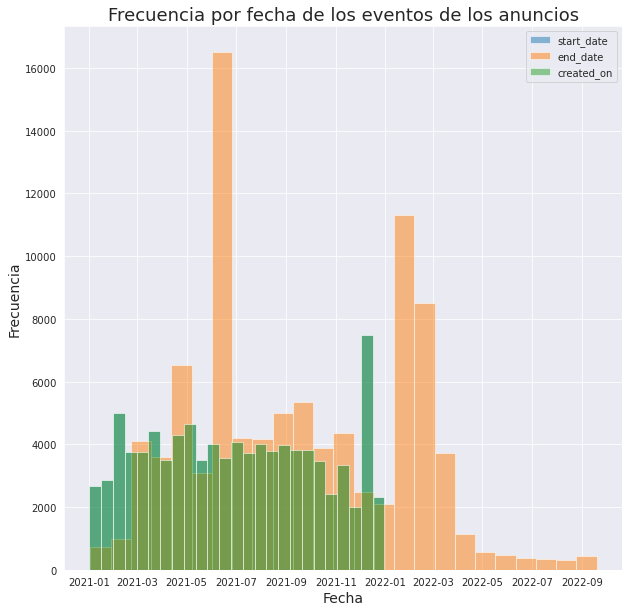

In [24]:

plt.figure(figsize=(10, 10))
plt.hist(ds_filtrado.start_date, bins=25, alpha=0.5, label="start_date")
plt.hist(ds_filtrado.end_date, bins=25, alpha=0.5, label="end_date")
plt.hist(ds_filtrado.created_on, bins=25, alpha=0.5, label="created_on")
plt.xlabel("Fecha", size=14)
plt.ylabel("Frecuencia", size=14)
plt.title("Frecuencia por fecha de los eventos de los anuncios", size=18)
plt.legend(loc='upper right')


En este grafico se puede apreciar la distribución de las variables que hacen referencia a las fechas de creacion, alta y baja de los anuncios. Podemos ver que la distribución de las fechas de creación coincide con la distribución de las fechas de alta del anuncio, lo cual tiene sentido que así sea ya que la fecha de creación del anuncio es la primer versión del anuncio en ser dada de alta. 

###  Distribución de barrios
Primero vemos la cantidad de apariciones de los barrios por anuncio en la siguiente tabla:

In [25]:
ds_filtrado['place_l3'].value_counts()

Palermo                 14308
Belgrano                 8898
Caballito                7168
Recoleta                 6282
Villa Urquiza            4673
Almagro                  4081
Nuñez                    3546
Villa Crespo             3189
Flores                   3110
Barrio Norte             2975
Balvanera                2553
Colegiales               1951
Villa Devoto             1921
Villa del Parque         1829
Saavedra                 1829
Puerto Madero            1493
San Telmo                1380
San Cristobal            1300
San Nicolás              1295
Retiro                   1250
Barracas                 1246
Boedo                    1237
Floresta                 1195
Monserrat                1115
Parque Chacabuco         1073
Villa Pueyrredón         1011
Coghlan                   984
Villa Luro                727
Mataderos                 719
Chacarita                 697
Liniers                   668
Villa Ortuzar             662
Parque Patricios          639
Villa Luga

Como podemos observar, hay demasiados barrios con pocas apariciones, por lo que nos centraremos en visualizar los primeras 10 barrios que mas aparecen. Agrupando al resto en una nueva categoria llamada "Otras".

In [26]:
top10 = ds_filtrado['place_l3'].value_counts().head(10)

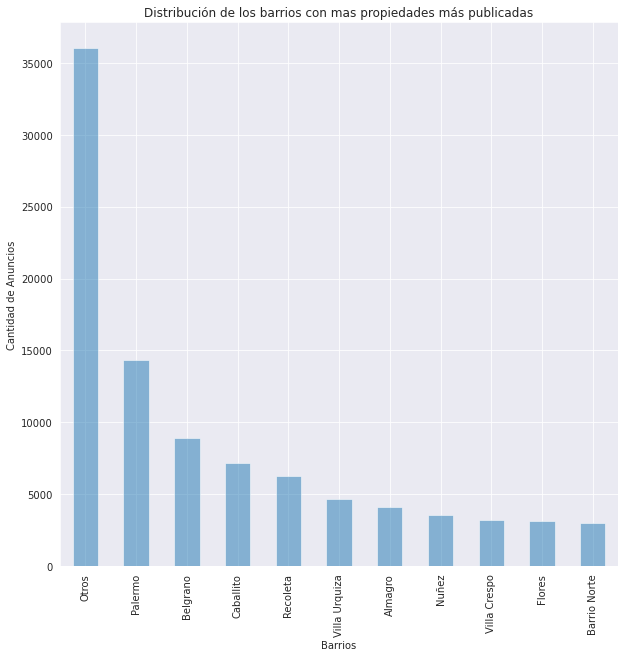

In [27]:
ds_otros_barrios = ds_filtrado[~ds_filtrado['place_l3'].isin(
    top10.index)]  # tomamos solo con las observaciones que no pertenecen al top 10 de barrios
frecuencia_otras = ds_otros_barrios.shape[0]
otras = pd.Series(data=[frecuencia_otras], index=["Otros"])
distribucion_por_barrios = pd.concat([otras, top10])

ax = distribucion_por_barrios.plot.bar(alpha=0.5,
                                       title="Distribución de los barrios con mas propiedades más publicadas",
                                       xlabel="Barrios", ylabel="Cantidad de Anuncios", figsize=(10, 10))

El barrio de Palermo es la que tiene mas propiedades publicadas

### Distribución de tipos de propiedad

Para analizar la distribucion de la variable property_type vamos a agrupar las apariciones en un grafico de barras por tipo de propiedad

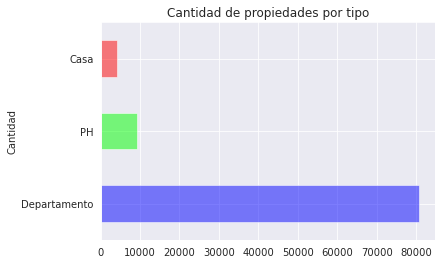

In [28]:
colores = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]
grf = ds_filtrado['property_type'].value_counts().plot.barh(alpha=0.5, color=colores,
                                                            title="Cantidad de propiedades por tipo", ylabel="Cantidad")

A simple vista se puede ver que la mayoria de publicaciones son de departamentos por una amplia diferencia

### Distribución de latitud y longitud
Para analizar la longitud y latitud vamos a utilizar un grafico de a pares ya que nos aporta más información sobre su distribución, pudiendo visualizar la localización de la propiedad. Adicionalmente se distinguirá por el tipo de propiedad.

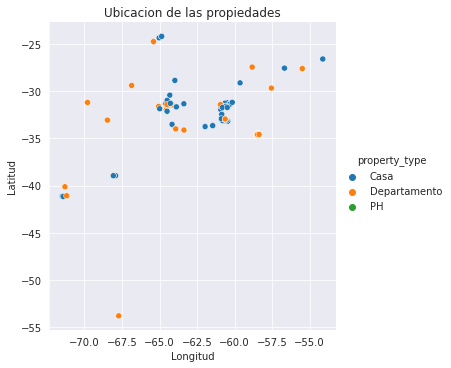

In [29]:
#grf=ds_filtrado.plot.scatter(x="latitud", y="longitud", s=10).set(title="Distribucion de observaciones por latitud y longitud",xlabel='Age',ylabel='Fare') 
sns.relplot(data=ds_filtrado, x="longitud", y="latitud", hue="property_type").set(title="Ubicacion de las propiedades",
                                                                                  xlabel='Longitud', ylabel='Latitud')

Podemos ver que la mayoria de propiedades publicadas se encuentran concentradas en un área en particular, donde mayormente son de tipo Casa. Y al alejarse se ven departamentos distanciados entre sí.

### Distribución de habitaciones y baños

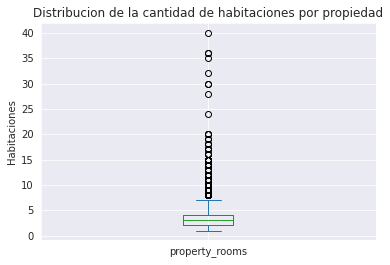

In [30]:
grf = ds_filtrado.property_rooms.plot.box(title="Distribucion de la cantidad de habitaciones por propiedad",
                                          ylabel="Habitaciones")

Podemos ver que hay una gran cantidad de outliers, siendo 40 el que mas se aleja, para visualizar mejor la distribucion del boxplot veremos un nuevo grafico sin considerar los outliers.

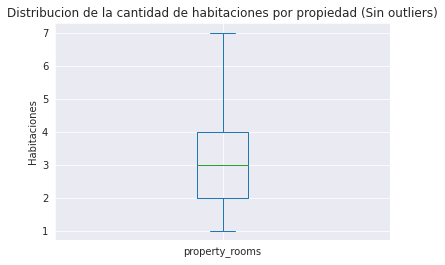

In [31]:
q1 = ds_filtrado.property_rooms.quantile(q=0.25)
q3 = ds_filtrado.property_rooms.quantile(q=0.75)
iqr = q3 - q1
max = q3 + (iqr * 1.5)

property_rooms_filtrado = ds_filtrado[ds_filtrado.property_rooms <= max].property_rooms
grf = property_rooms_filtrado.plot.box(title="Distribucion de la cantidad de habitaciones por propiedad (Sin outliers)",
                                       ylabel="Habitaciones")

Ahora si podemos visualizar mejor los valores de la mediana, q3, q1 y los bigotes. Que toman la siguiente cantidad de habitaciones:

*   Bigotes: 1 y 7.
*   Cuartil 1: 2
*   Mediana: 3.
*   Cuartil 3: 4.





Hacemos el mismo procedimiento ver la distribución de la cantidad de baños por propiedad

<AxesSubplot:title={'center':'Distribucion de la cantidad de baños por propiedad'}, ylabel='Baños'>

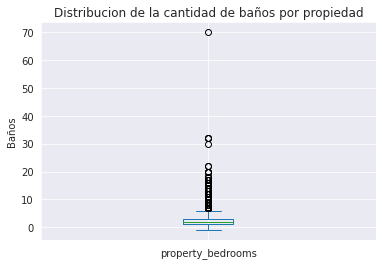

In [32]:
ds_filtrado.property_bedrooms.plot.box(title="Distribucion de la cantidad de baños por propiedad", ylabel="Baños")

Vemos que esta vez hay mas distancia entre el outlier mas alejado y el resto de outliers.

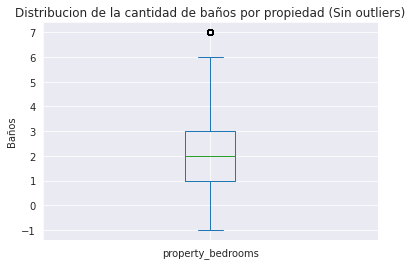

In [33]:
q1 = ds_filtrado.property_rooms.quantile(q=0.25)
q3 = ds_filtrado.property_rooms.quantile(q=0.75)
iqr = q3 - q1
max = q3 + (iqr * 1.5)

property_bedrooms_filtrado = ds_filtrado[ds_filtrado.property_bedrooms <= max].property_bedrooms
grf = property_bedrooms_filtrado.plot.box(title="Distribucion de la cantidad de baños por propiedad (Sin outliers)",
                                          xlabel=" ", ylabel="Baños")

En este caso toman los siguientes valores:

*   Bigotes: -1 y 6.
*   Cuartil 1: 1.
*   Mediana: 2.
*   Cuartil 3: 3.


### Distribución de precio

Para analizar la distribución del precio, como es un tipo de variable continua y cada observación puede tomar un valor en un rango muy grande, optamos por hacer una agrupación por rangos de precios, obteniendo una categoria por cada rango.
Vamos a considerar la mediana para establecer los limites entre cada grupo, consideramos que es un buen valor para dividir al conjunto en partes ya que no se ve afectado drasticamente por outliers (como si sucede con la media).

In [34]:
print(f"La mediana del precio es: {ds_filtrado.property_price.median()}")

La mediana del precio es: 143900.0


<AxesSubplot:title={'center':'Distribucion de los precios de las propiedades'}, ylabel='Rango de precios'>

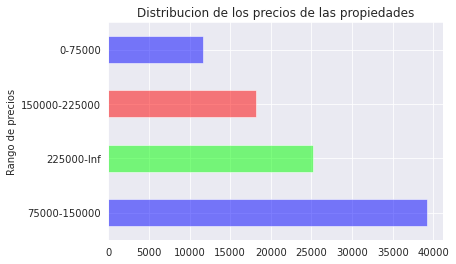

In [35]:
# Tomamos valores alrededor de la mediana
property_price_grouped = pd.cut(ds_filtrado.property_price, bins=[0, 75000, 150000, 225000, float("inf")],
                                labels=["0-75000", "75000-150000", "150000-225000", "225000-Inf"], include_lowest=True)
property_price_grouped.value_counts().plot.barh(alpha=0.5, color=colores,
                                                title="Distribucion de los precios de las propiedades",
                                                xlabel="Rango de precios", ylabel="Frecuencia")

Podemos ver que la mayoria de propiedades estan dentro del rango de 75000 y 150000 USD.

### Distribución de superficie total y cubierta

Utilizaremos un violin plot para cada variable. 

<AxesSubplot:xlabel='property_surface_total'>

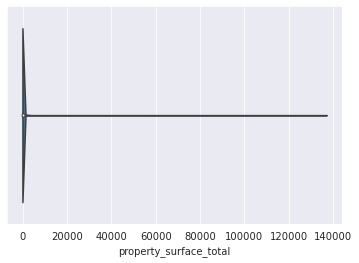

In [36]:
sns.violinplot(ds_filtrado.property_surface_total)

A simple vista no esta muy claro el gráfico por la cantidad de outliers que hay, por lo que dejaremos de lado la mayoria de outliers para interpretarlo mas en detalle.

<AxesSubplot:xlabel='property_surface_total'>

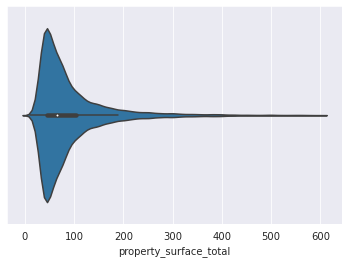

In [37]:
ds_surface_sin_outliers = ds_filtrado[ds_filtrado.property_surface_total < 600]
sns.violinplot(ds_surface_sin_outliers.property_surface_total)

Podemos ver que entre 0 y 100 se encuentra la mayor densidad

Hacemos el mismo procedimiento para visualizar la distribución de la superficie cubierta de la propiedad

<AxesSubplot:xlabel='property_surface_covered'>

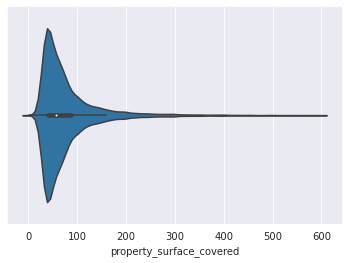

In [38]:
ds_surface_covered_sin_outliers = ds_filtrado[ds_filtrado.property_surface_covered < 600]
sns.violinplot(ds_surface_covered_sin_outliers.property_surface_covered)

Se nota que el grafico de property_surface_total es similar al de property_surface_covered, teniendo el segundo una densidad levemente menor. 

## Correlación entre variables

A continuación analizaremos la correlación entre las variables cuantitativas, primero visualizando la distribución a pares entre estas.

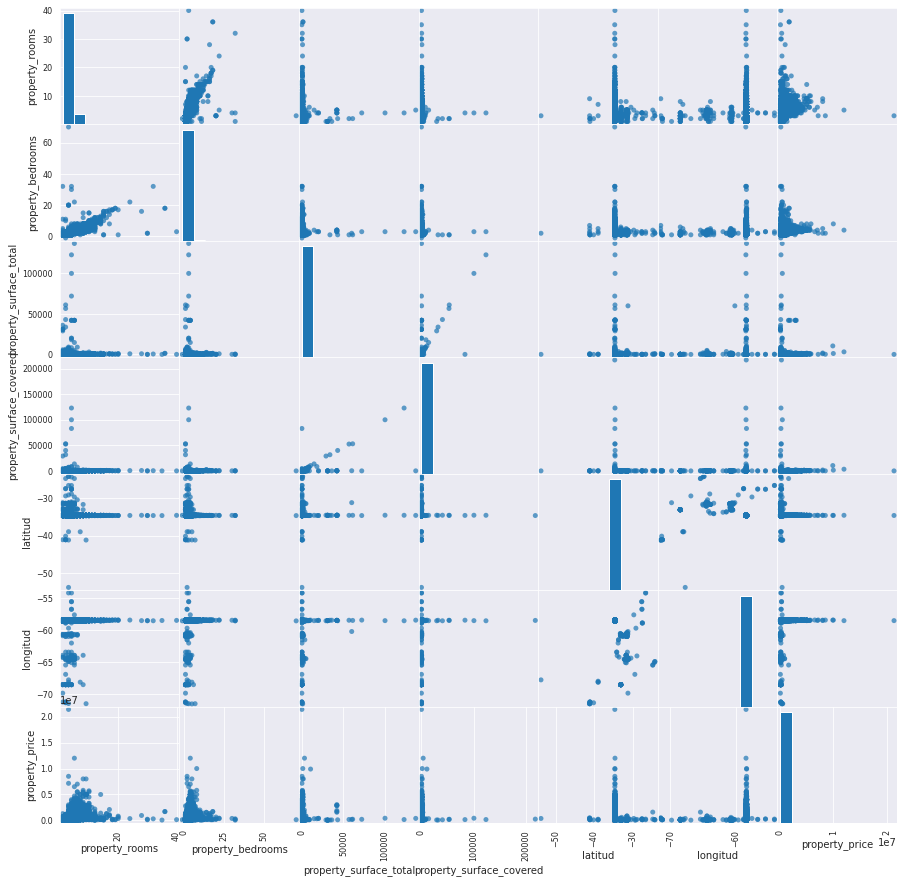

In [39]:
quantitative_dataset = ds_filtrado[cuantitativas_filtradas]
ax = scatter_matrix(quantitative_dataset, alpha=0.7, figsize=(15, 15), s=100)

Si bien a simple vista no esta muy claro que variables están correlacionadas entre sí, podemos suponer que puede llegar a haber relación entre property_rooms y property_bedrooms, property_surface_total y property_surface_covered, property_price y property_rooms, property_price y property_bedrooms. Las cuales tiene sentido que pudiesen tener algún tipo de relación.

Además podemos considerar en menor medida que haya una relación entre longitud y latitud (cosa que no necesariamente tendría que ser así)




Analizaremos la correlación lineal entre variables por medio de la medición del coeficiente de Pearson

In [40]:
correlations = quantitative_dataset.corr()
correlations

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,latitud,longitud,property_price
property_rooms,1.000000,0.871940,0.067211,0.076097,0.005521,-0.008324,0.488934
property_bedrooms,0.871940,1.000000,0.067702,0.075075,0.003162,-0.008556,0.425386
property_surface_total,0.067211,0.067702,1.000000,0.604311,0.025348,-0.015056,0.085235
property_surface_covered,0.076097,0.075075,0.604311,1.000000,0.002352,-0.001155,0.056238
latitud,0.005521,0.003162,0.025348,0.002352,1.000000,-0.239235,0.016635
longitud,-0.008324,-0.008556,-0.015056,-0.001155,-0.239235,1.000000,0.023314
property_price,0.488934,0.425386,0.085235,0.056238,0.016635,0.023314,1.000000


Haremos un heatmap que nos permite visualizar mejor la correlación

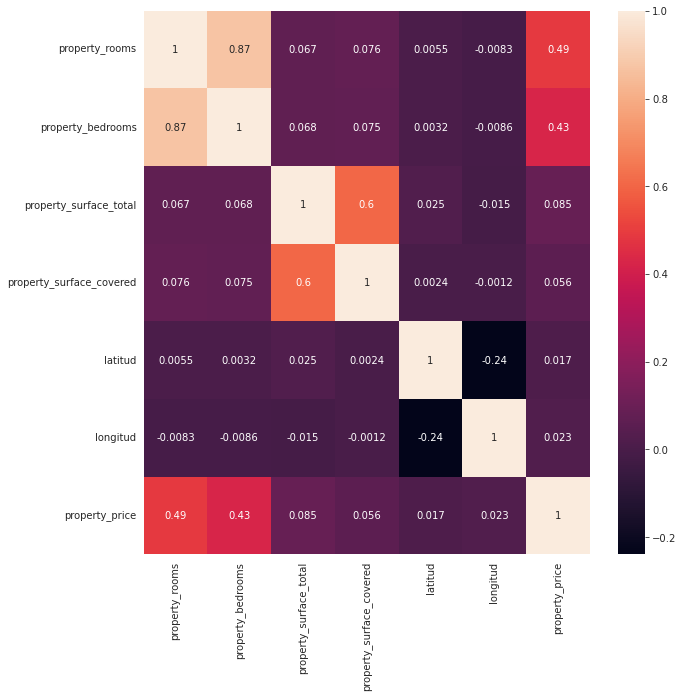

In [41]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(quantitative_dataset.corr(), annot=True)

Luego de calcular el coeficiente de Pearson donde los que resultan cercanos a 1 indican una gran correlación entre sí, los que tienden a 0 tienen poca correlación y los cercanos a -1 presentan una notable correlación negativa.

Veremos si las variables que parecían relacionarse anteriormente realmente lo hacen:


In [42]:
posible_correlations = [('property_rooms', 'property_bedrooms'), ('property_price', 'property_bedrooms'),
                        ('property_price', 'property_rooms'), ('property_surface_total', 'property_surface_covered'),
                        ('longitud', 'latitud')]
for corr in posible_correlations:
    print(f"Entre {corr[0]} y {corr[1]}:{round(correlations.loc[corr[0], corr[1]], 2)}")

Entre property_rooms y property_bedrooms:0.87
Entre property_price y property_bedrooms:0.43
Entre property_price y property_rooms:0.49
Entre property_surface_total y property_surface_covered:0.6
Entre longitud y latitud:-0.24


Podemos sacar las siguientes conclusiones sobre las variables que parecian relacionarse:


*   Hay mucha relación entre la cantidad de habitaciones y ambientes.
*   Hay menos relación entre la superficie total y superficie cubierta de la propiedad.
*   Casi no hay relación entre el precio y la cantidad de habitaciones.
*   Casi no hay relación entre el precio y la cantidad de ambientes.
*   No hay relación entre la latitud y la longitud.





## Análisis de valores faltantes

Ahora analizaremos los datos faltantes del dataset.

### Porcentaje de valores faltantes por columna



id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
place_l2                      0.000000
place_l3                      0.442445
place_l4                     96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


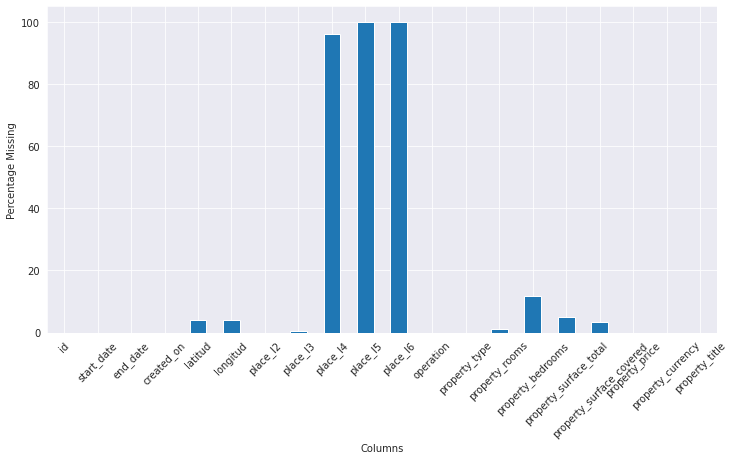

In [43]:
percent_missing = ds_filtrado.isna().sum() * 100 / len(ds_filtrado)
plt.figure(figsize=(12, 6))
percent_missing.plot.bar(x='index', rot=45)
plt.xlabel("Columns")
plt.ylabel("Percentage Missing")
rows = ds_filtrado.shape[0]
print(ds_filtrado.isna().sum() / rows * 100)

A simple vista podemos ver que las columnas place_l4,place_l5 y place_l6 practicamente no tienen datos, procederemos a eliminarlas.

### Porcentaje de datos faltantes por fila

<AxesSubplot:>

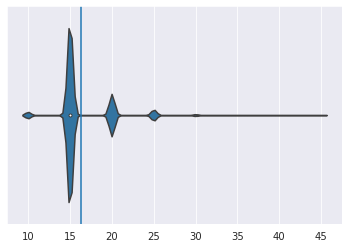

In [44]:
column_count = ds_filtrado.shape[1]
ds_plot = ds_filtrado.T.isna().sum() * 100 / column_count

plt.axvline(ds_plot.mean())
sns.violinplot(ds_plot)

Analizaremos nuevamente el porcentaje por fila luego de trabajar con las columnas

### Procesado de columnas

Descartaremos la columna id debido a que no es relevante para nuestro análisis. No podemos usar un dato uníco porque no representa ninguna característica relevante.

In [45]:
ds_filtrado['id'].head()

25    CyZu6IaZgmQYGk8jmPajCg==
42    d3Z0MblSb2IMBoOBMGJEEQ==
43    rL7qPkQnomsMGu2ViS3sBw==
49    vuX/ccLAMVml4qWRFcOJUA==
51    ZTtSCeqZ3HUgf5jjwEzRcw==
Name: id, dtype: object

Como mencionamos anteriormente, evaluaremos descartar place_l4 por la cantidad de valores faltantes que hay.

In [46]:
ds_filtrado['place_l4'].value_counts()

Palermo Hollywood    1576
Palermo Chico        1092
Palermo Soho          804
Palermo Viejo         171
Name: place_l4, dtype: int64

In [47]:
ds_filtrado['place_l2'].value_counts()

Capital Federal    94249
Name: place_l2, dtype: int64

In [48]:
ds_filtrado['property_currency'].value_counts()

USD    94249
Name: property_currency, dtype: int64

Como son pocas observaciones y todas corresponden al barrio de Palermo, descartaremos esta columna.
Además, como mencionamos más arriba, la columna created_on siempre es igual a la columna start_date, por lo que también la descartaremos.
Por otro lado, como filtramos solo las propiedades de CABA eliminaremos la columna place_l2 ya que tiene un único valor. Por el mismo motivo eliminaremos la columna property_currency.

In [49]:
# Voy a dejar el id para chequear duplicados más tarde.
ds_filtrado.drop(axis="columns",
                 columns=["created_on", "place_l2", "place_l4", "place_l5", "place_l6", "property_currency"],
                 inplace=True)
print(f"Nuestras nuevas columnas son:\n{ds_filtrado.columns.tolist()}")

Nuestras nuevas columnas son:
['id', 'start_date', 'end_date', 'latitud', 'longitud', 'place_l3', 'operation', 'property_type', 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_price', 'property_title']


### Analisis de faltantes por fila

Ahora que nos quedamos solo con las columnas deseadas, analizaremos nuevamente los datos faltantes por fila.

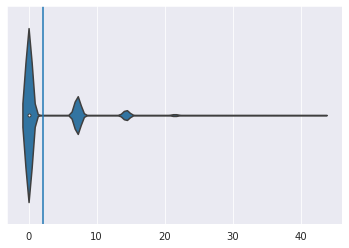

In [50]:
column_count = ds_filtrado.shape[1]
ds_plot = ds_filtrado.T.isna().sum() * 100 / column_count

sns.violinplot(ds_plot)
plt.axvline(ds_plot.mean())

Como podemos ver en el gráfico, la cantidad de datos faltantes bajó muchísimo al eliminar las columnas. Tenemos algunos registros con 5 o 10% de datos faltantes, veremos que falta

In [51]:
row_missing_data = ds_filtrado.T.isna().sum() * 100 / column_count
row_missing_data.value_counts()

0.000000     72863
7.142857     16019
14.285714     4333
21.428571      820
28.571429      110
35.714286      103
42.857143        1
dtype: int64

In [52]:
dataset_perc = row_missing_data.value_counts() * 100 / ds_filtrado.shape[0]
print(f"La cantidad de faltantes segun porcentaje representan\n{dataset_perc}")

La cantidad de faltantes segun porcentaje representan
0.000000     77.309043
7.142857     16.996467
14.285714     4.597396
21.428571     0.870036
28.571429     0.116712
35.714286     0.109285
42.857143     0.001061
dtype: float64


Ahora que elegimos las columnas deseadas, veremos nuevamente los porcentajes por columna para preparar algunas imputaciones

In [53]:
def plot_missing_by_column(dataset):
    percent_missing = dataset.isna().sum() * 100 / len(dataset)
    plt.figure(figsize=(12, 6))
    percent_missing.plot.bar(x='index', rot=45)
    plt.xlabel("Columns")
    plt.ylabel("Percentage Missing")
    rows = dataset.shape[0]
    print(dataset.isna().sum() / rows * 100)

id                           0.000000
start_date                   0.000000
end_date                     0.000000
latitud                      3.957602
longitud                     3.957602
place_l3                     0.442445
operation                    0.000000
property_type                0.000000
property_rooms               1.107704
property_bedrooms           11.657418
property_surface_total       5.139577
property_surface_covered     3.558658
property_price               0.000000
property_title               0.000000
dtype: float64


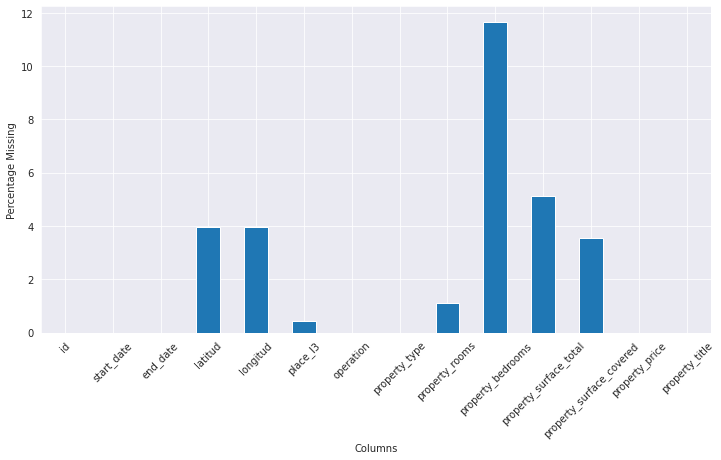

In [54]:
plot_missing_by_column(ds_filtrado)

Para los que tienen el dato del barrio podríamos tomar como latitud/longitud el centro geográfico del barrio

## Reparacion de datos faltantes

Ahora analizaremos columna a columna como podemos reparar esos datos.

#### Latitud y Longitud

In [55]:
len(ds_filtrado[ds_filtrado.latitud.isna()]), ds_filtrado[
    ds_filtrado.latitud.isna()].longitud.isna().sum()

(3730, 3730)

Como vemos, en esos 3730 los registros faltan ambos datos, veremos que datos sí están presentes en esos registros

id                            0.000000
start_date                    0.000000
end_date                      0.000000
latitud                     100.000000
longitud                    100.000000
place_l3                      4.557641
operation                     0.000000
property_type                 0.000000
property_rooms                3.297587
property_bedrooms            13.324397
property_surface_total        7.319035
property_surface_covered      4.343164
property_price                0.000000
property_title                0.000000
dtype: float64


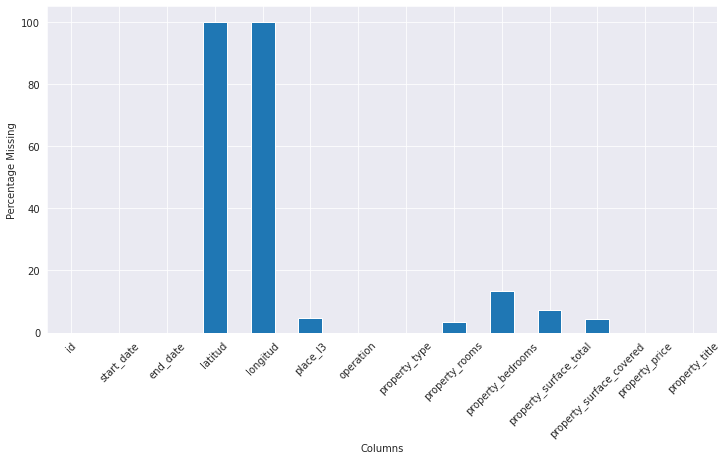

In [56]:
plot_missing_by_column(ds_filtrado[ds_filtrado.latitud.isna()])

In [57]:
ds_filtrado[ds_filtrado.latitud.isna()]['place_l3'].value_counts()

Palermo                 907
Belgrano                651
Nuñez                   229
Recoleta                227
Barrio Norte            185
Caballito               170
Almagro                 162
Villa Urquiza           151
Flores                  115
Villa Crespo            111
San Telmo                96
Balvanera                80
Puerto Madero            69
Coghlan                  47
San Nicolás              46
Congreso                 39
Once                     36
Tribunales               32
Monserrat                27
Retiro                   18
Constitución             14
Barracas                 14
Abasto                   12
Paternal                 10
Colegiales               10
Liniers                  10
Saavedra                  9
Villa del Parque          9
Floresta                  8
Mataderos                 7
Parque Chacabuco          7
San Cristobal             7
Villa Devoto              7
Villa Pueyrredón          5
Villa Lugano              4
Pompeya             

In [58]:
percentage = ds_filtrado[ds_filtrado.latitud.isna()]['place_l3'].isna().sum() / len(
    ds_filtrado[ds_filtrado.latitud.isna()]['place_l3']) * 100
print(f"Los datos faltantes en la columna place_l3 representan el {round(percentage, 3)}%")

Los datos faltantes en la columna place_l3 representan el 4.558%


### Pre Imputacion de ambientes

property_rooms    1.107704
dtype: float64


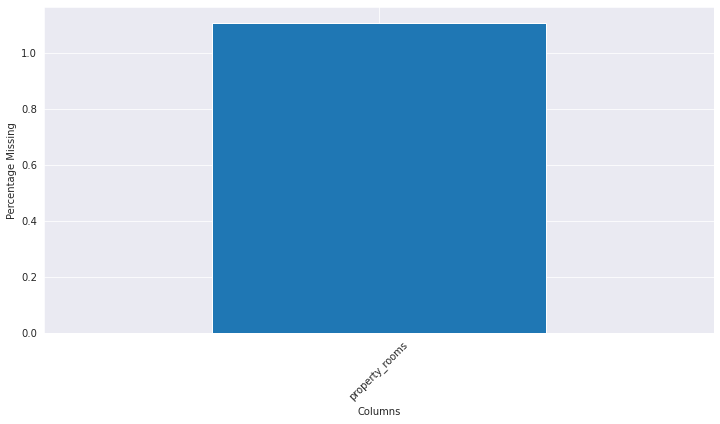

In [59]:
plot_missing_by_column(ds_filtrado[['property_rooms']])

#### Reparacion de ambientes faltantes en base al titulo de la propiedad

In [60]:
datos_a_reparar = ds_filtrado[['property_title', 'property_rooms']].reset_index()
ambientes_faltantes = datos_a_reparar[datos_a_reparar['property_rooms'].isna()]

print(f"cantidad inicial de ambientes a reparar: {len(ds_filtrado[ds_filtrado['property_rooms'].isna()])}")

regex = re.compile(r"(\d+ \bambientes?\b)")
regex2 = re.compile(r"(\d+\ \b\bamb\b *)")

a = {}
for titulo in ambientes_faltantes.property_title:
    if (len(re.findall(regex, titulo.lower())) > 0):
        a[titulo] = re.findall(regex, titulo.lower())
    if (len(re.findall(regex2, titulo.lower())) > 0):
        a[titulo] = re.findall(regex2, titulo.lower())

for i in ds_filtrado.index:
    if ds_filtrado.loc[i, 'property_title'] in a:
        if len(a[ds_filtrado.loc[i, 'property_title']]) > 0:
            ds_filtrado.loc[i, 'property_rooms'] = float("".join(a[ds_filtrado.loc[i, 'property_title']]).split(" ")[0])
        if ("monoambiente" or "un ambiente" or "mono" or "mono ambiente") in str(
                ds_filtrado.loc[i, 'property_title']).lower():
            ds_filtrado.loc[i, 'property_rooms'] = float(1)
        if "dos ambientes" in str(ds_filtrado.loc[i, 'property_title']).lower():
            ds_filtrado.loc[i, 'property_rooms'] = float(2)
        if "tres ambientes" in str(ds_filtrado.loc[i, 'property_title']).lower():
            ds_filtrado.loc[i, 'property_rooms'] = float(3)
        if "cuatro ambientes" in str(ds_filtrado.loc[i, 'property_title']).lower():
            ds_filtrado.loc[i, 'property_rooms'] = float(4)
        if "cinco ambientes" in str(ds_filtrado.loc[i, 'property_title']).lower():
            ds_filtrado.loc[i, 'property_rooms'] = float(5)
        if "seis ambientes" in str(ds_filtrado.loc[i, 'property_title']).lower():
            ds_filtrado.loc[i, 'property_rooms'] = float(6)

print(f"cantidad de ambientes faltantes post reparacion: {len(ds_filtrado[ds_filtrado['property_rooms'].isna()])}")

cantidad inicial de ambientes a reparar: 1044
cantidad de ambientes faltantes post reparacion: 831


### Post Imputacion de ambientes

property_rooms    0.881707
dtype: float64


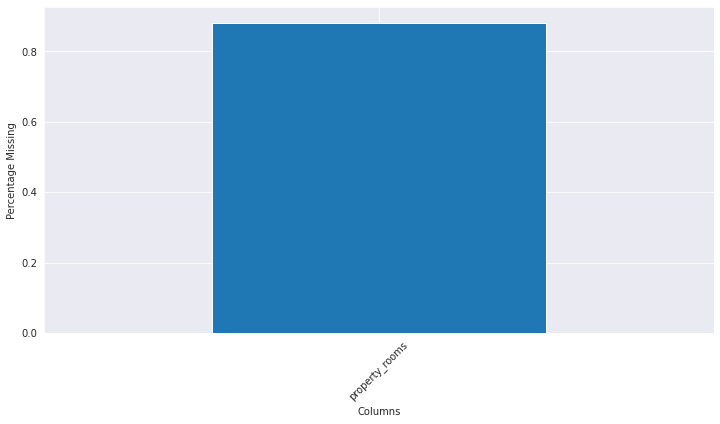

In [61]:
plot_missing_by_column(ds_filtrado[['property_rooms']])

Como las que quedan sin datos son pocas observaciones, las eliminaremos

In [62]:
ds_filtrado.dropna(axis='index', subset=['property_rooms'], inplace=True)
ds_filtrado[ds_filtrado.property_rooms.isna()]

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title


property_rooms    0.0
dtype: float64


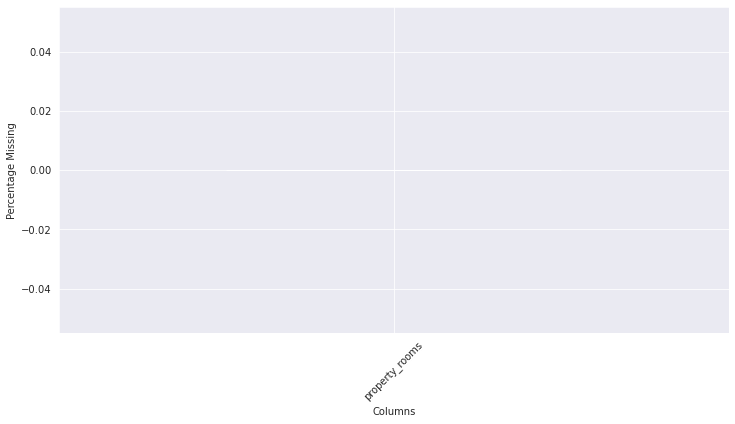

In [63]:
plot_missing_by_column(ds_filtrado[['property_rooms']])

### Pre Imputacion de Habitaciones

property_bedrooms    11.34685
dtype: float64


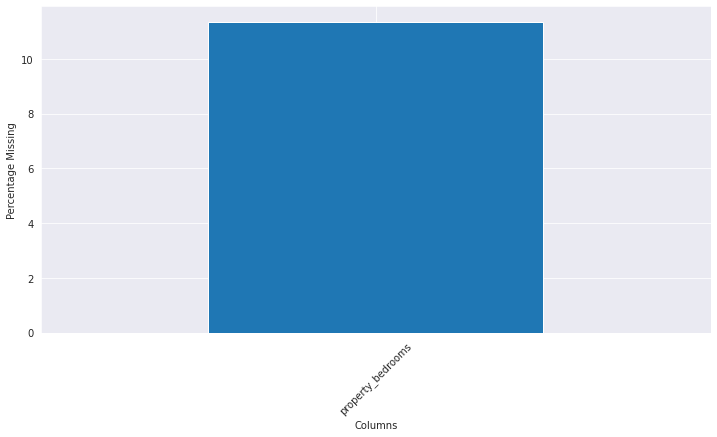

In [64]:
plot_missing_by_column(ds_filtrado[['property_bedrooms']])

#### Reparacion de habitaciones faltantes en base a los ambientes

In [65]:
print(f"El total de habitaciones es: {len(ds_filtrado.property_bedrooms)}")
habitaciones_invalidas = ds_filtrado.loc[(ds_filtrado['property_bedrooms'] > ds_filtrado['property_rooms'])]
print(
    f"El total de habitaciones invalidas es: {len(habitaciones_invalidas)}. Constituye al {(len(habitaciones_invalidas) * 100) // len(ds_filtrado.property_bedrooms)}% de los datos del ds")
habitaciones_invalidas

El total de habitaciones es: 93418
El total de habitaciones invalidas es: 163. Constituye al 0% de los datos del ds


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
2516,uKy3ZC5YQ9kPZ1ztj7CKjw==,2021-12-17,2022-02-09,-34.557573,-58.459926,Belgrano,Venta,Departamento,1.0,2.0,51.0,51.0,150000.0,Venta Departamento 2 Ambientes Belgrano a Estr...
3028,epPD4VV0HDOb5M1cNSTFEw==,2021-02-20,2021-03-01,-34.640603,-58.417313,Pompeya,Venta,PH,1.0,2.0,27.0,22.0,53000.0,"P.H. AL FRENTE C/ ENTRADA IND., S/ EXPENSAS"
4928,69j280NshNyMCYcFqsmhlw==,2021-09-20,2022-01-27,-34.645031,-58.373672,Barracas,Venta,Departamento,1.0,2.0,43.0,37.0,80000.0,Amplio Monoambiente - actualmente divido - con...
6355,PZJRORTIAvMTvI3A+FLDUQ==,2021-10-29,2021-11-03,-34.577180,-58.451264,Colegiales,Venta,Departamento,6.0,8.0,424.0,324.0,660000.0,DEPARTAMENTOS CON 2 UNIDADES COMPLEMENTARIAS E...
9491,ybK3GgBY+bzoeAA+YONVcQ==,2021-05-18,2021-06-05,-34.580919,-58.430717,Palermo,Venta,Departamento,1.0,2.0,97.0,97.0,263000.0,Departamento - Palermo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451218,7krE2YAxkwyebVtlLkuFcA==,2021-12-16,2022-01-27,-34.557917,-58.459907,Belgrano,Venta,Departamento,1.0,2.0,49.0,45.0,136300.0,Departamento - Belgrano
452275,DzALh3DQ7Dp1VmfhkZvL4w==,2021-12-16,2022-02-09,-34.596921,-58.402560,Recoleta,Venta,Departamento,4.0,5.0,108.0,100.0,220000.0,VENTA DEPTO 4 AMB DEPENDENCIA BALCON BARRIO NORTE
458670,naEatqtTCG8ALXICib4ZxQ==,2021-01-05,2022-08-12,-34.577390,-58.475421,Villa Urquiza,Venta,PH,5.0,6.0,125.0,100.0,265000.0,Alvarez Thomas 2400 Exc PH SIN EXPENSAS- 5 am...
459345,tDk6Qv0vzIsLSAkJbV/O/Q==,2021-01-05,2021-06-24,-34.578661,-58.428397,Palermo,Venta,Departamento,2.0,3.0,82.0,73.0,192000.0,Excelente oportunidad dpto en Palermo Hollywoo...


Si tomamos en cuenta que el 2% de los valores tienen mas habitaciones que ambientes, podriamos pensar en imputar los datos faltantes elimanando estas filas y haciendo que los valores que sean NAN, ahora sean habitaciones = ambientes-1

In [66]:
habitaciones_con_amb_menos_1 = ds_filtrado[ds_filtrado.property_rooms == (ds_filtrado.property_bedrooms + 1)]
print(
    f"Las habitaciones que son Ambientes - 1 son: {len(habitaciones_con_amb_menos_1)}. Constituyen al {(len(habitaciones_con_amb_menos_1) * 100) // len(ds_filtrado.property_bedrooms)}% de los datos")
habitaciones_con_amb_menos_1

Las habitaciones que son Ambientes - 1 son: 69773. Constituyen al 74% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur
53,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,2022-01-27,-34.623886,-58.412746,Boedo,Venta,PH,2.0,1.0,61.0,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO
56,ahcEMvB66wjPz0SYWZQDBw==,2021-09-09,2021-09-26,-34.629398,-58.425852,Boedo,Venta,Departamento,2.0,1.0,62.0,44.0,100000.0,VENTA 2 ambientes EN DUPLEX sin Expensas en Boedo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460066,6jIQwemq6hMLyB3vfivamA==,2021-01-05,2021-06-05,-34.632484,-58.432932,Parque Chacabuco,Venta,Departamento,3.0,2.0,NaN,76.0,129000.0,DEPARTAMENTO VENTA PARQUE CHACABUCO 3 AMBIENTES
460067,pKo6hHHPBZJydrHIn5S5Tg==,2021-01-05,2021-11-04,-34.636285,-58.400321,Parque Patricios,Venta,Departamento,3.0,2.0,66.0,64.0,130000.0,Atractivo depto en el edificio histórico del P...
460072,v4f5Un9jO7hsD02MWLkKBQ==,2021-01-05,2022-09-02,-34.603245,-58.489810,Villa del Parque,Venta,Departamento,4.0,3.0,130.0,100.0,220000.0,Espectacular 4 amb130m2 con Balcon Terraza!!!
460073,Aq/Z+XyS8FHbOOxed4xtTw==,2021-01-05,2021-02-17,-34.614063,-58.482814,Villa del Parque,Venta,Departamento,3.0,2.0,68.0,60.0,161000.0,3 ambientes con cochera listo para habitar!


Como notamos que las habitaciones que son ambientes - 1 en el dataset son: 4255 y constituyen al 4% de los datos, optamos por hacer una regresion lineal para que se pueda predecir el valor de las habitaciones en base a los ambientes que tenemos, ya que el 4% no es un valor representativo

In [67]:
print(f"Valor inicial de habitaciones faltantes en el ds: {ds_filtrado.property_bedrooms.isna().sum()}")

Valor inicial de habitaciones faltantes en el ds: 10600


In [68]:
## Approach de Regresion para imputar los valores faltantes en las habitaciones

lr = LinearRegression()

ds_sin_rooms_vacios = ds_filtrado[~(ds_filtrado.property_rooms.isna())]

habitaciones_completas = ds_sin_rooms_vacios[~(ds_sin_rooms_vacios.property_bedrooms.isna())]
habitaciones_faltantes = ds_sin_rooms_vacios[ds_sin_rooms_vacios.property_bedrooms.isna()]
train_bedrooms = habitaciones_completas.property_bedrooms.values
train_rooms = habitaciones_completas.property_rooms.values

train_bedrooms = train_bedrooms.reshape(-1, 1)
train_rooms = train_rooms.reshape(-1, 1)

lr.fit(train_rooms, train_bedrooms)

test_rooms = habitaciones_faltantes.property_rooms.values.reshape(-1, 1)

predicted_bedrooms = lr.predict(test_rooms)

habitaciones_faltantes_copy = habitaciones_faltantes.copy()
habitaciones_faltantes_copy['result'] = np.round(predicted_bedrooms)

print(
    f"Proseguimos en verificar que podemos usar el metodo de regresion lineal ya que la variable que vamos a imputar esta entre un rango de 0 - 5")
print(
    f"Notemos que las habitaciones mayores a cinco son: {len(habitaciones_faltantes_copy[habitaciones_faltantes_copy.result > 5])}")

for i in ds_filtrado.index:
    if i in habitaciones_faltantes_copy.index:
        ds_filtrado.loc[i, 'property_bedrooms'] = habitaciones_faltantes_copy.loc[i, 'result']

print(ds_filtrado.property_bedrooms.isna().sum())

Proseguimos en verificar que podemos usar el metodo de regresion lineal ya que la variable que vamos a imputar esta entre un rango de 0 - 5
Notemos que las habitaciones mayores a cinco son: 31
0


### Post Imputacion de habitaciones

property_bedrooms    0.0
dtype: float64


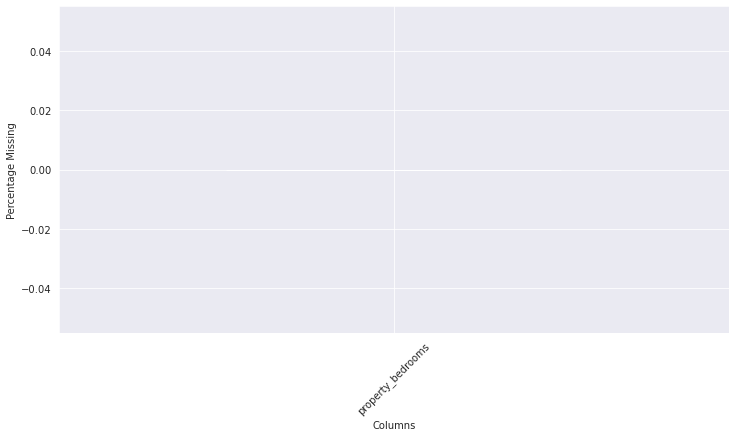

In [69]:
plot_missing_by_column(ds_filtrado[['property_bedrooms']])

### Pre Imputación de Superficie total

property_surface_total    4.962641
dtype: float64


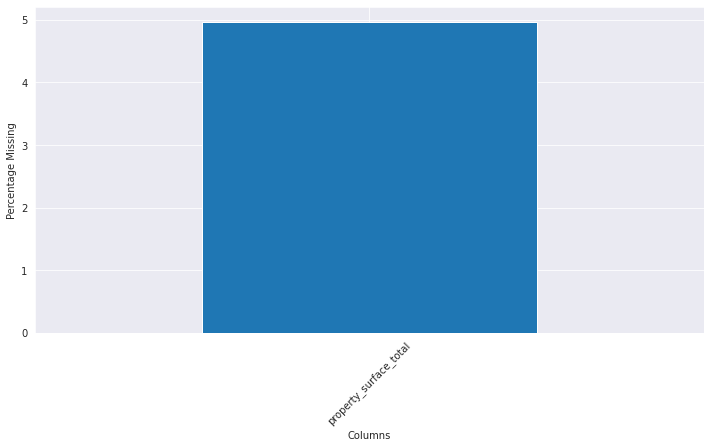

In [70]:
plot_missing_by_column(ds_filtrado[['property_surface_total']])

Como a simple vista muchos registros tienen superficie cubierta, veremos en cuantos faltan ambos datos

In [71]:
ds_filtrado[ds_filtrado.property_surface_total.isna()][ds_filtrado.property_surface_covered.isna()]

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title


#### Reparación de datos faltantes en superficie cubierta

Como todos los datos tienen la superficie cubierta, repararemos estos datos tomando ese valor como superficie total

In [72]:
ds_filtrado.loc[ds_filtrado.property_surface_total.isna(), 'property_surface_total'] = ds_filtrado.loc[
    ds_filtrado.property_surface_total.isna(), 'property_surface_covered']
len(ds_filtrado.loc[ds_filtrado.property_surface_total.isna()])

0

### Post Imputación de Superficie total

property_surface_total    0.0
dtype: float64


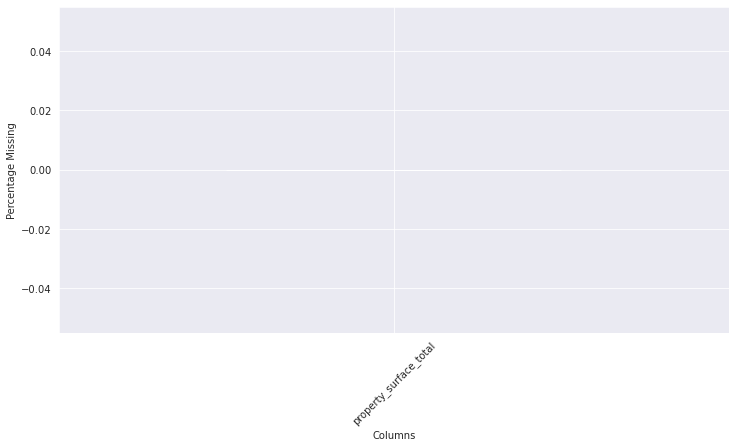

In [73]:
plot_missing_by_column(ds_filtrado[['property_surface_total']])

### Pre Imputación de superficie cubierta

In [74]:
ds_filtrado[ds_filtrado.property_surface_covered.isna()]

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
407,LpZsZFe0+FCnEIugLb5hGg==,2021-09-09,2022-01-27,-34.572982,-58.437378,Palermo,Venta,Departamento,3.0,2.0,53.0,NaN,145000.0,Departamento - Palermo
409,cq0OzDv1TWdUBj1cDBpk/Q==,2021-09-09,2022-03-09,-34.591596,-58.404697,Palermo,Venta,Departamento,2.0,1.0,36.0,NaN,70000.0,Departamento - Barrio Norte
658,Ve7j1PIdF65BBnfBKvHD/Q==,2021-09-09,2021-09-26,-34.557302,-58.468573,Belgrano,Venta,Departamento,1.0,1.0,25.0,NaN,100000.0,Loft monoambiente de diseño y balcon a estrenar!!
671,xUeKv67isQAxDsZCfrNUgQ==,2021-09-09,2021-12-24,-34.558206,-58.442923,Belgrano,Venta,Departamento,4.0,3.0,135.0,NaN,410000.0,Excelente depto 4 amb de 135 m2 con Balcón Ter...
705,ByHtbIabCDhajDRDvbXAzg==,2021-09-09,2021-10-31,-34.641487,-58.480619,Floresta,Venta,Departamento,3.0,2.0,74.0,NaN,90000.0,Departamento - Floresta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459388,YVsj+twhKJ37lLd0mz84mA==,2021-01-05,2022-02-02,NaN,NaN,Palermo,Venta,Departamento,3.0,2.0,56.0,NaN,220000.0,Departamento de 3 Ambientes-Apto Profesional-C...
459460,zLAZW8hoL0A2guKWm0yeVQ==,2021-01-05,2021-04-21,-34.566755,-58.431589,Palermo,Venta,Departamento,3.0,2.0,82.0,NaN,205000.0,Departamento - Palermo
459466,SAnTGJlzxrYy0+vAgt+AoA==,2021-01-05,2021-03-18,-34.579681,-58.434233,Palermo,Venta,Departamento,1.0,1.0,33.0,NaN,113000.0,Departamento - Palermo Hollywood
459877,9mqEHWX+ITaMYNhdVX++ww==,2021-01-05,2021-07-29,-34.581008,-58.449328,Colegiales,Venta,Departamento,3.0,2.0,73.0,NaN,249000.0,Hermoso 3 ambientes con cochera y baulera en C...


property_surface_covered    3.498255
dtype: float64


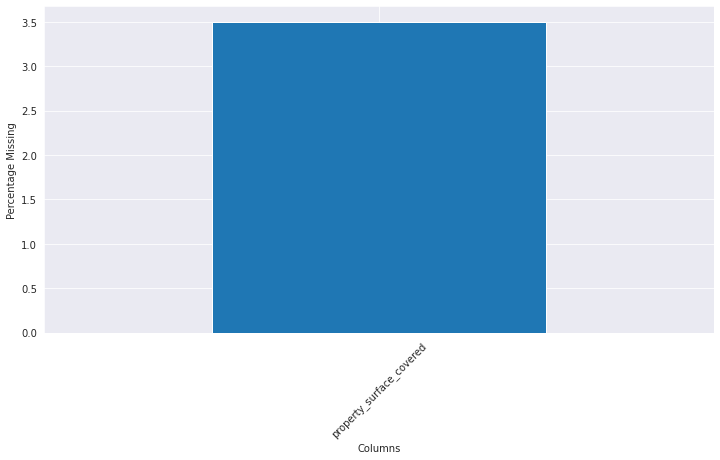

In [75]:
plot_missing_by_column(ds_filtrado[['property_surface_covered']])

##### Reparación de datos faltantes en Superficie cubierta

Como tenemos 3231 registros nulos para la superficie cubierta, imputaremos de la misma forma los registros que son Departamentos porque su superficie total suele ser muy cercana a la cubierta

In [76]:
ds_filtrado[ds_filtrado.property_surface_covered.isna()].property_type.value_counts()

Departamento    2935
PH               231
Casa             102
Name: property_type, dtype: int64

In [77]:
ds_filtrado.loc[(ds_filtrado.property_surface_covered.isna()) & (
        ds_filtrado.property_type == 'Departamento'), 'property_surface_covered'] = ds_filtrado.loc[
    (ds_filtrado.property_surface_covered.isna()) & (
            ds_filtrado.property_type == 'Departamento'), 'property_surface_total']

len(ds_filtrado.loc[(ds_filtrado.property_surface_covered.isna()) & (ds_filtrado.property_type == 'Departamento')])

0

Los 310 registros restantes los eliminaremos porque representan un porcentaje muy bajo y repararlos de esta forma puede ser impreciso.

In [78]:
ds_filtrado.dropna(axis='index', subset=['property_surface_covered'], inplace=True)
ds_filtrado[ds_filtrado.property_surface_covered.isna()]

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title


Volvemos a evaluar el porcentaje de datos faltantes

id                          0.000000
start_date                  0.000000
end_date                    0.000000
latitud                     3.879250
longitud                    3.879250
place_l3                    0.366332
operation                   0.000000
property_type               0.000000
property_rooms              0.000000
property_bedrooms           0.000000
property_surface_total      0.000000
property_surface_covered    0.000000
property_price              0.000000
property_title              0.000000
dtype: float64


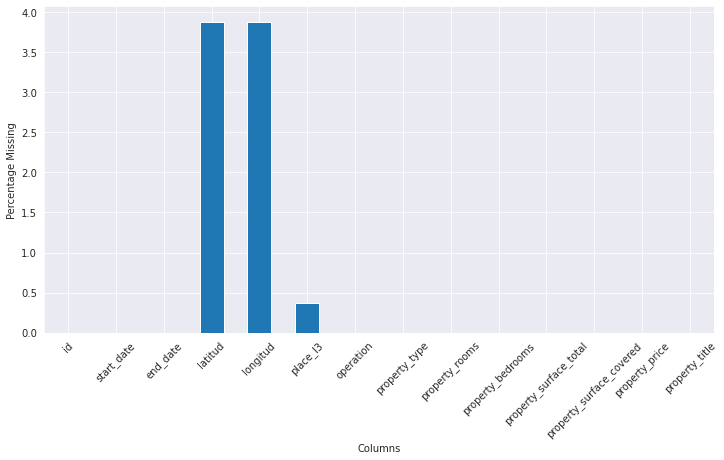

In [79]:
percent_missing = ds_filtrado.isna().sum() * 100 / len(ds_filtrado)
plt.figure(figsize=(12, 6))
percent_missing.plot.bar(x='index', rot=45)
plt.xlabel("Columns")
plt.ylabel("Percentage Missing")
rows = ds_filtrado.shape[0]
print(ds_filtrado.isna().sum() / rows * 100)

### Pre imputación de latitud y longitud

In [80]:
len(ds_filtrado[(ds_filtrado.latitud.isna())])

3611

In [81]:
ds_filtrado[(ds_filtrado.latitud.isna()) & (ds_filtrado.longitud.isna())]

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
405,VOJ5gKpDfBjlwRKVgIHcYQ==,2021-09-09,2021-10-09,NaN,NaN,Palermo,Venta,Departamento,3.0,2.0,85.0,85.0,200000.0,Departamento - Palermo
462,8MK0bnH+IIBCzauugN1Dzw==,2021-09-09,2022-03-09,NaN,NaN,Palermo,Venta,Departamento,2.0,1.0,50.0,50.0,153000.0,"Departamento 2 AMBIENTES en Palermo, Capital F..."
463,ujMVUbCEkvGVq7zpdfk0xQ==,2021-09-09,2021-09-14,NaN,NaN,Palermo,Venta,Departamento,3.0,2.0,185.0,185.0,890000.0,Espectacular Loft 185 m2 en Venta en Palacio A...
670,nBdoSIExRSs1yspHrNriXQ==,2021-09-09,2021-11-03,NaN,NaN,Belgrano,Venta,Departamento,4.0,3.0,180.0,103.0,495000.0,DEPARTAMENTOS EN VENTA 4 AMBIENTES EN BELGRANO...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459762,5E/ItvppG+w1mtR4Fz1fNA==,2021-01-05,2022-06-12,NaN,NaN,Recoleta,Venta,Departamento,6.0,4.0,169.0,159.0,450000.0,Departamento de 4 dormitorios en venta en Reco...
459929,0LQJ6wsDRYUoP9EKiGeFOw==,2021-01-05,2022-06-02,NaN,NaN,Barrio Norte,Venta,Departamento,3.0,2.0,115.0,108.0,310000.0,Departamento en venta en Barrio Norte con luz ...
459930,xASW/OLXKSi7uSRPwW/pCQ==,2021-01-05,2021-06-05,NaN,NaN,Barrio Norte,Venta,Departamento,3.0,2.0,54.0,50.0,165000.0,Departamento - Barrio Norte
459944,H/jrDS4t0C9K/i/mo+zJjQ==,2021-01-05,2022-06-12,NaN,NaN,San Nicolás,Venta,Departamento,4.0,2.0,110.0,110.0,295000.0,Paris en Buenos Aires - Edificio antiguo. 2 do...


Podemos ver que faltan ambos datos en todos los casos. Para repararlos tomaremos el centro geográfico del barrio en el que encuentran usando el dataset de barrios.

In [82]:
## TODO: Reparar lat/long

In [83]:
ds_filtrado[(ds_filtrado.latitud.isna()) & (ds_filtrado.longitud.isna()) & (ds_filtrado.place_l3.isna())]

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
3099,cLeo0+I+Zt0/4dwt9KeFlg==,2021-02-20,2021-03-01,NaN,NaN,NaN,Venta,Casa,3.0,2.0,69.0,53.0,54600.0,Venta Duplex 3 amb. Complejo Quimaral I - San ...
5942,RXLax1BaL57FteQH3HMBLw==,2021-10-29,2022-01-08,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,87.0,87.0,117000.0,impecable 3 Ambientes de 88 m2!!!! con 2 baños...
6699,v+sxjFL/W8jKIb6kZ/utHQ==,2021-02-09,2021-06-05,NaN,NaN,NaN,Venta,Casa,7.0,3.0,390.0,390.0,795000.0,Magnífica casa a la venta de 7 ambientes en Ab...
7204,U65AD6YXmo1PjgUmHGMtag==,2021-02-09,2022-07-17,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,20.0,20.0,50000.0,Departamento - Centro (Capital Federal)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458690,uzOE5TSle78c4dgqiJ8hYg==,2021-01-05,2021-03-01,NaN,NaN,NaN,Venta,Casa,3.0,2.0,80.0,80.0,120000.0,Casa a reciclar 3 Amb. en San Martin
458696,UxrImoZVU0nEah53uM/NSg==,2021-01-05,2021-03-01,NaN,NaN,NaN,Venta,Casa,3.0,2.0,60.0,60.0,75000.0,CASA 3 AMBIENTES CON TERRAZA
459187,eKBe4k1ocBLyz6ntXQfPiQ==,2021-01-05,2021-03-01,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,41.0,41.0,75000.0,San Martín. Centro depto 2 amb a estrenar.
459195,E8hNlBjeRdD9Cr759qVghQ==,2021-01-05,2021-03-01,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,44.0,44.0,128000.0,San Martin Ctro. s/ San Lorenzo Impecable Dpto...


In [84]:
ds_filtrado[(ds_filtrado.latitud.isna()) & (ds_filtrado.longitud.isna()) & (ds_filtrado.place_l3.isna())].index


Int64Index([    25,   3099,   5942,   6699,   7204,  19426,  25588,  31871,
             39238,  44423,
            ...
            447263, 448188, 448210, 458616, 458683, 458690, 458696, 459187,
            459195, 459199],
           dtype='int64', length=145)

Tenemos 142 casos irreparables, los eliminaremos

## Grafico de los barrios de CABA

In [85]:
# Proceso el archivo de los barrios de CABA
barrios = gpd.read_file('./barrios.geojson')
barrios.head()

,BARRIO,COMUNA,PERIMETRO,AREA,OBJETO,geometry
0,CHACARITA,15.0,7724.852955,3.115707e+06,BARRIO,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366..."
1,PATERNAL,15.0,7087.513295,2.229829e+06,BARRIO,"MULTIPOLYGON (((-58.46558 -34.59656, -58.46562..."
2,VILLA CRESPO,15.0,8131.857075,3.615978e+06,BARRIO,"MULTIPOLYGON (((-58.42375 -34.59783, -58.42495..."
3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,BARRIO,"MULTIPOLYGON (((-58.49461 -34.61487, -58.49479..."
4,ALMAGRO,5.0,8537.901368,4.050752e+06,BARRIO,"MULTIPOLYGON (((-58.41287 -34.61412, -58.41282..."


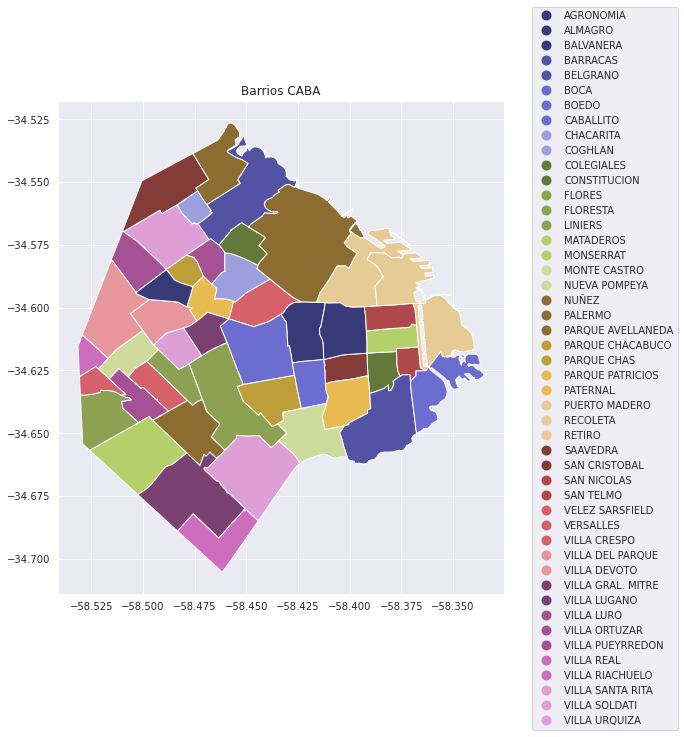

In [86]:
# Realizo el grafico de los barrios de CABA
fig, ax = plt.subplots(figsize=(8, 10))
barrios.plot(column='BARRIO', categorical=True, legend=True, ax=ax, cmap='tab20b')

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.4, 1.2))

ax.set(title='Barrios CABA')
plt.show()

## Analisis de Valores Atipicos

### Univariados

#### Metodo IQR

In [87]:
def calculate_univariate_iqr(column, dataset):
    print(f"cantidad de datos del ds: {len(dataset)}")

    # 1er cuartil para property_rooms
    q1 = column.quantile(0.25)

    # 3er cuartil para property_rooms
    q3 = column.quantile(0.75)
    med = column.median()

    # region IQR
    iqr = q3 - q1

    # Bigotes altos y bajos
    limite_superior = q3 + (1.5 * iqr)
    limite_inferior = q1 - (1.5 * iqr)

    outliers = dataset[(column <= limite_inferior) | (column >= limite_superior)]
    print(f"outliers encontrados para los {column.name}: {len(outliers)}")
    print(f"hay {len(outliers) * 100 // len(dataset)}% de outliers de {column.name} sobre el ds")
    print(f"limit sup: {limite_superior}, limite inf: {limite_inferior}")

    outliers_grafico = dataset[(column >= limite_inferior) & (column <= limite_superior)][column.name]

    plt.figure(figsize=(5, 5))
    plt.boxplot(outliers_grafico)
    plt.show()


In [88]:
def boxplot_outliers_edges(series, moderated_outliers=True):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    if moderated_outliers:
        value = 1.5
    else:
        value = 3

    max = q3 + (value * iqr)
    min = q1 - (value * iqr)

    return min, max

In [89]:
def boxplot_with_outliers(dataset, column_name):
    column = dataset[column_name]
    moderated_min, moderated_max = boxplot_outliers_edges(column)
    severe_min, severe_max = boxplot_outliers_edges(column, moderated_outliers=False)

    print(f"Moderated outliers limits [min: {moderated_min},max: {moderated_max}]")
    print(f"Severe outliers limits [min: {severe_min},max: {severe_max}]")

    plt.figure(figsize=(5, 10))
    column.plot.box()

    plt.axhline(moderated_min, label="Moderated")
    plt.axhline(moderated_max)
    plt.axhline(severe_min, color="r", label="Severe")
    plt.axhline(severe_max, color="r")
    #plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2)
    plt.legend(title="Limites")

##### Ambientes

cantidad de datos del ds: 93085
outliers encontrados para los property_rooms: 1471
hay 1% de outliers de property_rooms sobre el ds
limit sup: 7.0, limite inf: -1.0


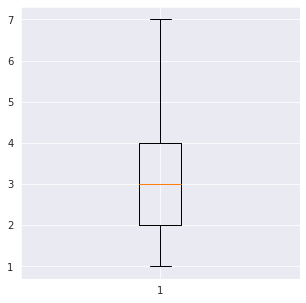

In [90]:
calculate_univariate_iqr(ds_filtrado.property_rooms, ds_filtrado)

Tomaremos 7 como límite superior y 0 como límite inferior ya que no tiene sentido que haya cantidad de habitaciones negativas.

In [91]:
outlier_inf_rooms_iqr = ds_filtrado[ds_filtrado['property_rooms'] < 0]
outlier_sup_rooms_iqr = ds_filtrado[ds_filtrado['property_rooms'] > 7]
print(
    f"Los outliers inf de rooms son: {len(ds_filtrado[ds_filtrado['property_rooms'] < 0])}. Constituyen al {(len(ds_filtrado[ds_filtrado['property_rooms'] < 0]) * 100) // len(ds_filtrado.property_rooms)}% de los datos")
print(
    f"Los outliers sup de rooms son: {len(ds_filtrado[ds_filtrado['property_rooms'] > 7])}. Constituyen al {(len(ds_filtrado[ds_filtrado['property_rooms'] > 7]) * 100) // len(ds_filtrado.property_rooms)}% de los datos")

Los outliers inf de rooms son: 0. Constituyen al 0% de los datos
Los outliers sup de rooms son: 732. Constituyen al 0% de los datos


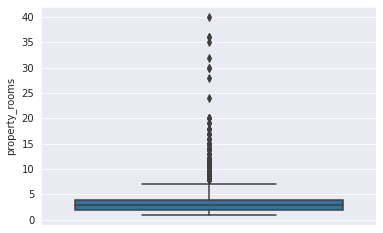

In [92]:
sns.boxplot(y=ds_filtrado.property_rooms)
plt.show()

Vemos ahora que todos los datos están dentro del rango intercuartil permitido

##### Habitaciones

Moderated outliers limits [min: -2.0,max: 6.0]
Severe outliers limits [min: -5.0,max: 9.0]


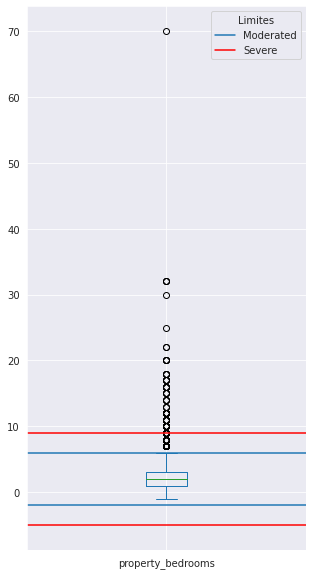

In [93]:
boxplot_with_outliers(ds_filtrado, 'property_bedrooms')

cantidad de datos del ds: 93085
outliers encontrados para los property_bedrooms: 501
hay 0% de outliers de property_bedrooms sobre el ds
limit sup: 6.0, limite inf: -2.0


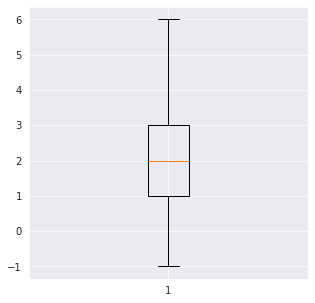

In [94]:
calculate_univariate_iqr(ds_filtrado.property_bedrooms, ds_filtrado)

In [95]:
outlier_inf_bedrooms_iqr = ds_filtrado[ds_filtrado['property_bedrooms'] < 0]
outlier_sup_bedrooms_iqr = ds_filtrado[ds_filtrado['property_bedrooms'] > 6]
print(
    f"Los outliers inf de bedrooms son: {len(ds_filtrado[ds_filtrado['property_bedrooms'] < 0])}. Constituyen al {(len(ds_filtrado[ds_filtrado['property_bedrooms'] < 0]) * 100) // len(ds_filtrado.property_bedrooms)}% de los datos")
print(
    f"Los outliers sup de bedrooms son: {len(ds_filtrado[ds_filtrado['property_bedrooms'] > 6])}. Constituyen al {(len(ds_filtrado[ds_filtrado['property_bedrooms'] > 195]) * 100) // len(ds_filtrado.property_bedrooms)}% de los datos")

Los outliers inf de bedrooms son: 1. Constituyen al 0% de los datos
Los outliers sup de bedrooms son: 267. Constituyen al 0% de los datos


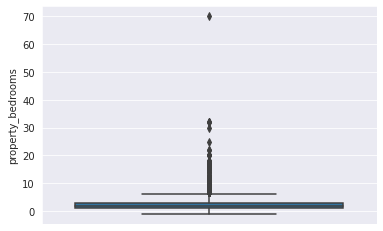

In [96]:
sns.boxplot(y=ds_filtrado.property_bedrooms)
plt.show()

Eliminaremos una observacion en particular que fue detectada como outlier ya que dice tener -1 habitaciones. Este valor no tiene ningun sentido logico en nuestro domino de problema

In [97]:
print(f"fila a eliminar: {ds_filtrado[ds_filtrado['property_bedrooms'] < 0]}")
indice_outlier = outlier_inf_bedrooms_iqr.index
ds_filtrado.drop(indice_outlier, inplace=True)
print(f"Se han eliminado: {len(indice_outlier)} registros")

fila a eliminar:                               id start_date   end_date    latitud   longitud  \
406880  3WI+zCCMeb9TR5kOBm7rhg== 2021-01-07 2021-03-18 -34.577595 -58.495185   

             place_l3 operation property_type  property_rooms  \
406880  Villa Urquiza     Venta  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
406880               -1.0                    61.0                      43.0   

        property_price                                     property_title  
406880        125000.0  Jardines de Roosevelt - Hermoso 3 ambientes co...  
Se han eliminado: 1 registros


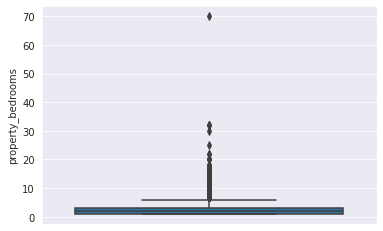

In [98]:
sns.boxplot(y=ds_filtrado.property_bedrooms)
plt.show()

##### Superficie Total

cantidad de datos del ds: 93084
outliers encontrados para los property_surface_total: 7673
hay 8% de outliers de property_surface_total sobre el ds
limit sup: 191.5, limite inf: -44.5


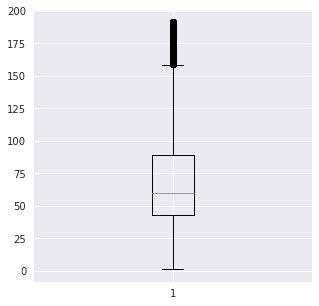

In [99]:
calculate_univariate_iqr(ds_filtrado.property_surface_total, ds_filtrado)

Elegimos tomar como outlier a viviendas que tengan una superifice menor a 18 ya que, en base a los documentos que leimos, este es el minimo necesario para que una persona viva en una vivienda. 18 m2 minimo. Observar los links adjuntos:

https://observatoriociudad.org/microdepartamentos-y-codigo-de-edificacion/

http://ssplan.buenosaires.gob.ar/webfiles/100_preguntas/ce_art_3_8_1_1_1_areas_y_lados_minimos_de_locales_de_vivienda_individual_y_colectiva.pdf

Eliminaremos las viviendas que tienen menos de 18 m2 de superficie

In [100]:
indices = ds_filtrado[ds_filtrado.property_surface_total < 18]
#ds_filtrado.drop(indices, inplace=True)

In [101]:
inf, sup = boxplot_outliers_edges(ds_filtrado.property_surface_total, False)
print(f"Nuestro rango intercuartil está comprendido entre: {inf}, {sup}")

Nuestro rango intercuartil está comprendido entre: -133.0, 280.0


In [102]:
outlier_inf_total_iqr = ds_filtrado[ds_filtrado['property_surface_total'] < 18]
outlier_sup_total_iqr = ds_filtrado[ds_filtrado['property_surface_total'] > 272]
print(
    f"Los outliers inf de sup total son: {len(ds_filtrado[ds_filtrado['property_surface_total'] < 18])}. Constituyen al {(len(ds_filtrado[ds_filtrado['property_surface_total'] < 18]) * 100) // len(ds_filtrado.property_surface_total)}% de los datos")
print(
    f"Los outliers sup de sup total son: {len(ds_filtrado[ds_filtrado['property_surface_total'] > 277])}. Constituyen al {(len(ds_filtrado[ds_filtrado['property_surface_total'] > 277]) * 100) // len(ds_filtrado.property_surface_total)}% de los datos")

Los outliers inf de sup total son: 96. Constituyen al 0% de los datos
Los outliers sup de sup total son: 3382. Constituyen al 3% de los datos


Visualizamos nuevamente el box-plot para entender que valores tienen las nuevas observaciones atipicas y ver si debemos seguir eliminando

Moderated outliers limits [min: -44.5,max: 191.5]
Severe outliers limits [min: -133.0,max: 280.0]


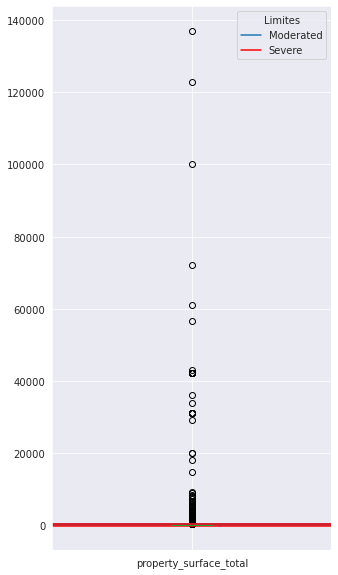

In [103]:
boxplot_with_outliers(ds_filtrado, ds_filtrado.property_surface_total.name)

Como tenemos outliers muy altos, el boxplot no se aprecia. Tomaremos solo los outliers severos para un primer análisis

272-500     2952
500-750      369
1000-inf     120
750-1000      57
0-272          0
Name: property_surface_total, dtype: int64


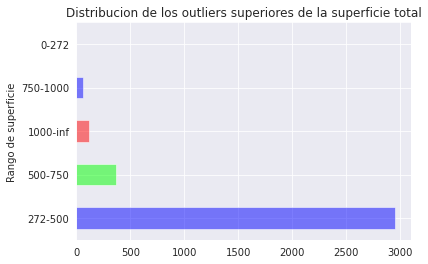

In [104]:
property_price_grouped = pd.cut(outlier_sup_total_iqr.property_surface_total,
                                bins=[0, 272, 500, 750, 1000, float("inf")],
                                labels=["0-272", "272-500", "500-750", "750-1000", "1000-inf"], include_lowest=True)
print(property_price_grouped.value_counts())
ax = property_price_grouped.value_counts().plot.barh(alpha=0.5, color=colores,
                                                     title="Distribucion de los outliers superiores de la superficie total",
                                                     xlabel="Rango de superficie", ylabel="Frecuencia")

In [105]:
surface_median = ds_filtrado[ds_filtrado.property_type == 'Casa'].property_surface_total.median()
print(
    f"Si bien la mediana de la superficite total es {surface_median} y limite superior de outliers severos es 272, consideramos que sigue siendo un valor válido, por lo tanto, descartaremos los valores mayores a 500")

Si bien la mediana de la superficite total es 230.0 y limite superior de outliers severos es 272, consideramos que sigue siendo un valor válido, por lo tanto, descartaremos los valores mayores a 500


In [106]:
outlier_sup_total_500 = ds_filtrado[ds_filtrado['property_surface_total'] > 500]
print(
    f"Los outliers superiores de sup total son: {len(ds_filtrado[ds_filtrado['property_surface_total'] > 500])}. Constituyen al {(len(ds_filtrado[ds_filtrado['property_surface_total'] > 500]) * 100) // len(ds_filtrado.property_surface_total)}% de los datos")

Los outliers superiores de sup total son: 546. Constituyen al 0% de los datos


Moderated outliers limits [min: -44.5,max: 191.5]
Severe outliers limits [min: -133.0,max: 280.0]


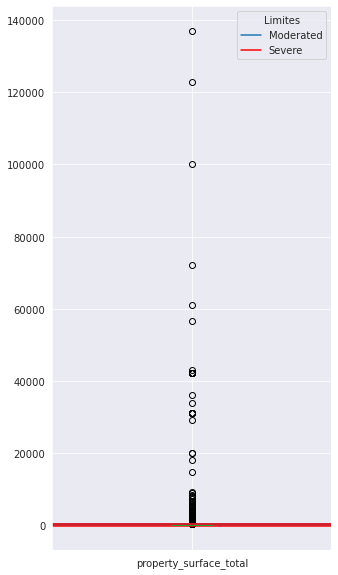

In [107]:
boxplot_with_outliers(ds_filtrado, 'property_surface_total')

##### Superficie cubierta

cantidad de datos del ds: 93084
outliers encontrados para los property_surface_covered: 7846
hay 8% de outliers de property_surface_covered sobre el ds
limit sup: 160.0, limite inf: -32.0


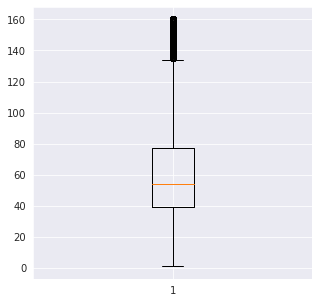

In [108]:
calculate_univariate_iqr(ds_filtrado.property_surface_covered, ds_filtrado)

In [109]:
outlier_inf_covered_iqr = ds_filtrado[ds_filtrado['property_surface_covered'] < 0]
outlier_sup_covered_iqr = ds_filtrado[ds_filtrado['property_surface_covered'] > 155]
print(
    f"Los outliers inf de sup cubierta son: {len(ds_filtrado[ds_filtrado['property_surface_covered'] < 0])}. Constituyen al {(len(ds_filtrado[ds_filtrado['property_surface_covered'] < 18]) * 100) // len(ds_filtrado.property_surface_covered)}% de los datos")
print(
    f"Los outliers sup de sup cubierta son: {len(ds_filtrado[ds_filtrado['property_surface_covered'] > 155])}. Constituyen al {(len(ds_filtrado[ds_filtrado['property_surface_covered'] > 155]) * 100) // len(ds_filtrado.property_surface_covered)}% de los datos")

Los outliers inf de sup cubierta son: 0. Constituyen al 0% de los datos
Los outliers sup de sup cubierta son: 8161. Constituyen al 8% de los datos


Moderated outliers limits [min: -32.0,max: 160.0]
Severe outliers limits [min: -104.0,max: 232.0]


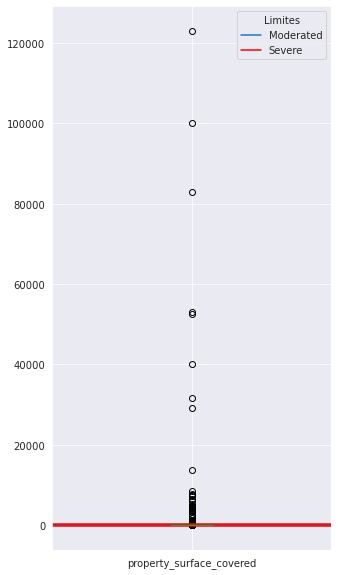

In [110]:
boxplot_with_outliers(ds_filtrado, 'property_surface_covered')

Como hay 1 observacion demasiado anómala, repeteriremos el análisis después de borrarla

In [111]:
indice_outlier = ds_filtrado[ds_filtrado.property_surface_covered > 50000].index
ds_filtrado.drop(indice_outlier, inplace=True)
print(f"Se han eliminado {len(indice_outlier)} registros")

Se han eliminado 5 registros


Moderated outliers limits [min: -32.0,max: 160.0]
Severe outliers limits [min: -104.0,max: 232.0]


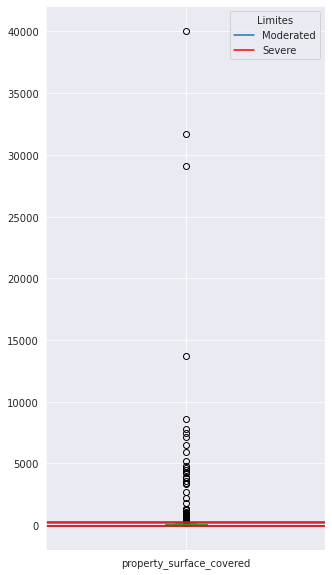

In [112]:
boxplot_with_outliers(ds_filtrado, 'property_surface_covered')

224-500     2571
0-224        715
500-750      156
1000-inf      31
750-1000      25
Name: property_surface_covered, dtype: int64


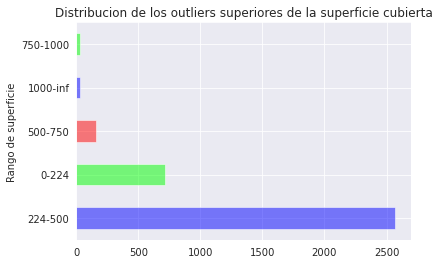

In [113]:
surface_total_grouped = pd.cut(outlier_sup_total_iqr.property_surface_covered,
                                bins=[0, 224, 500, 750, 1000, float("inf")],
                                labels=["0-224", "224-500", "500-750", "750-1000", "1000-inf"], include_lowest=True)
print(surface_total_grouped.value_counts())
ax = surface_total_grouped.value_counts().plot.barh(alpha=0.5, color=colores,
                                                     title="Distribucion de los outliers superiores de la superficie cubierta",
                                                     xlabel="Rango de superficie", ylabel="Frecuencia")

Inspeccionaremos los datos que se encuentran entre 224 y 500 $m^2$ de superficie cubierta

In [114]:
ds_filtrado[(ds_filtrado.property_surface_covered < 500) & (ds_filtrado.property_surface_covered > 224)]

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26 00:00:00.000000000,-34.633730,-58.424729,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06 00:00:00.000000000,-34.575053,-58.407958,Palermo,Venta,Departamento,4.0,3.0,282.0,256.0,2250000.0,Torre Vignoli 282 metros . 3 suites . 2 cocheras
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27 00:00:00.000000000,-34.577855,-58.408796,Palermo,Venta,Departamento,5.0,4.0,304.0,294.0,1200000.0,Departamento de 5 ambientes con dependencia -...
816,J4k6mcS3gHoFlin7DHZFAQ==,2021-09-09,2022-02-09 00:00:00.000000000,-34.588526,-58.384700,Recoleta,Venta,Departamento,7.0,4.0,295.0,295.0,1250000.0,"Retasado! Imponente piso alto,7amb.Recoleta."
834,DW1aOtw9rrmcRJKrXV8lQQ==,2021-09-09,2022-03-09 00:00:00.000000000,-34.586193,-58.396815,Recoleta,Venta,Departamento,9.0,4.0,390.0,340.0,1200000.0,“La Isla”-Gelly Obes-Copérnico-Espectacular pi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459757,lwx5hHp/XqVx2ZqOr8wr1Q==,2021-01-05,2022-06-11 00:00:00.000000000,-34.590382,-58.382945,Recoleta,Venta,Departamento,6.0,3.0,243.0,231.0,900000.0,Departamento de 3 o 4 dormitorios en venta en ...
459764,oX3aPs/sStr80cOS+VyxVw==,2021-01-05,2021-03-20 10:42:07.845036320,-34.586441,-58.387889,Recoleta,Venta,Departamento,8.0,4.0,383.0,383.0,1700000.0,Departamento frances con 2 cocheras en venta e...
459767,rOoHS/cWBIdCGwOvGz1eow==,2021-01-05,2021-03-20 10:42:07.845036320,-34.592185,-58.388462,Recoleta,Venta,Departamento,6.0,3.0,230.0,226.0,690000.0,Departamento en venta en Recoleta
459786,MlRoZnWv4WKgooXEfWRhUQ==,2021-01-05,2021-04-06 00:00:00.000000000,-34.591927,-58.407204,Recoleta,Venta,Departamento,5.0,4.0,258.0,258.0,380000.0,Departamento - Recoleta


##### Latitud y longitud

cantidad de datos del ds: 93079
outliers encontrados para los latitud: 557
hay 0% de outliers de latitud sobre el ds
limit sup: -34.51971696250001, limite inf: -34.6735696625


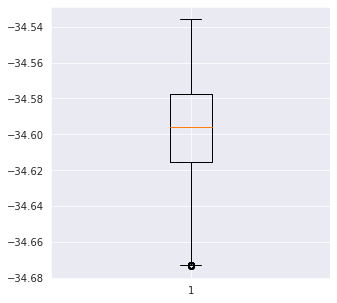

In [115]:
calculate_univariate_iqr(ds_filtrado.latitud, ds_filtrado)

cantidad de datos del ds: 93079
outliers encontrados para los longitud: 144
hay 0% de outliers de longitud sobre el ds
limit sup: -58.322634400000005, limite inf: -58.55263499999999


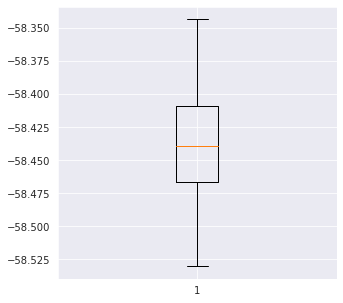

In [116]:
calculate_univariate_iqr(ds_filtrado.longitud, ds_filtrado)

Los datos de latitud y longitud son dificiles de analizar por medio del rango intercuartil dado que los datos representan variaciones muy pequeñas y no son faciles de imaginar sin una ubicación en el mapa. Haremos este análisis más adelante.

In [117]:
outlier_inf_latitud_iqr = ds_filtrado[ds_filtrado['latitud'] < -34]
outlier_sup_latitud_iqr = ds_filtrado[ds_filtrado['latitud'] > -34]
print(
    f"Los outliers inf de latitud son: {len(ds_filtrado[ds_filtrado['latitud'] < -34])}. Constituyen al {(len(quantitative_dataset[quantitative_dataset['latitud'] < -34]) * 100) // len(ds_filtrado.latitud)}% de los datos")
print(
    f"Los outliers sup de latitud son: {len(quantitative_dataset[quantitative_dataset['latitud'] > -34])}. Constituyen al {(len(quantitative_dataset[quantitative_dataset['latitud'] > -34]) * 100) // len(ds_filtrado.latitud)}% de los datos")

Los outliers inf de latitud son: 89338. Constituyen al 97% de los datos
Los outliers sup de latitud son: 179. Constituyen al 0% de los datos


#### Metodo Z score

In [118]:
def calculate_zscore_st(dataset, column):
    dataset_copy = dataset.copy()
    media = np.mean(column)
    std = np.std(column)
    dataset_copy[f'z_{column.name}'] = (column - media) / std
    return dataset_copy

Analisis de outliers con el metodo zscore para los ambientes

##### Ambientes

In [119]:
z_rooms_ds = calculate_zscore_st(ds_filtrado, ds_filtrado.property_rooms)
z_rooms_ds.head()

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_rooms
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,0.828029
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,0.126097
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,0.828029
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,-34.610027,-58.401934,Once,Venta,Departamento,4.0,2.0,104.0,104.0,146000.0,Venta departamento 4 ambientes Once,0.828029
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,-34.631621,-58.416825,Boedo,Venta,PH,4.0,2.0,73.0,73.0,250000.0,PH - Boedo,0.828029


Verificamos si se cumple la regla de oro para el caso de la variable Rooms

In [120]:
print(
    f"Los outliers sup de rooms son: {len(z_rooms_ds[z_rooms_ds['z_property_rooms'] > 3])}. Constituyen al {(len(z_rooms_ds[z_rooms_ds['z_property_rooms'] > 3]) * 100) // len(ds_filtrado.property_rooms)}% de los datos")
print(
    f"Los outliers inf de rooms son: {len(z_rooms_ds[z_rooms_ds['z_property_rooms'] < -3])}. Constituyen al {(len(z_rooms_ds[z_rooms_ds['z_property_rooms'] < -3]) * 100) // len(ds_filtrado.property_rooms)}% de los datos")

Los outliers sup de rooms son: 732. Constituyen al 0% de los datos
Los outliers inf de rooms son: 0. Constituyen al 0% de los datos


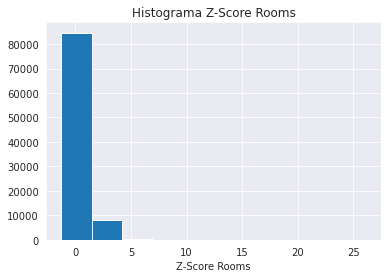

In [121]:
plt.hist(z_rooms_ds.z_property_rooms)
plt.title('Histograma Z-Score Rooms')
plt.xlabel('Z-Score Rooms')
plt.show()

##### Habitaciones

In [122]:
z_bedrooms_ds = calculate_zscore_st(ds_filtrado, ds_filtrado.property_bedrooms)
z_bedrooms_ds.head()

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_bedrooms
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,0.991540
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,0.087881
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,0.991540
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,-34.610027,-58.401934,Once,Venta,Departamento,4.0,2.0,104.0,104.0,146000.0,Venta departamento 4 ambientes Once,0.087881
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,-34.631621,-58.416825,Boedo,Venta,PH,4.0,2.0,73.0,73.0,250000.0,PH - Boedo,0.087881


In [123]:
print(
    f"Los outliers sup de bedrooms son: {len(z_bedrooms_ds[z_bedrooms_ds['z_property_bedrooms'] > 3])}.Constituyen al {(len(z_bedrooms_ds[z_bedrooms_ds['z_property_bedrooms'] > 3]) * 100) // len(ds_filtrado.property_bedrooms)}% de los datos")
z_bedrooms_ds[z_bedrooms_ds['z_property_bedrooms'] > 3]

Los outliers sup de bedrooms son: 501.Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_bedrooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26 00:00:00.000000000,-34.633730,-58.424729,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,7.317152
1040,hg7z9YXumyiWLjMo6ed2Eg==,2021-09-09,2022-03-09 00:00:00.000000000,-34.620750,-58.502759,Villa Luro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,Casa Ideal Dos Familias - Monte Castro,3.702517
1108,emutcNxb0N+nIgC7KPMFow==,2021-09-09,2022-03-09 00:00:00.000000000,-34.620750,-58.502759,Monte Castro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,Casa Ideal Dos Familias - Monte Castro,3.702517
1349,fwH71WfOi+vE4kdGMHfWNQ==,2021-09-09,2022-03-09 00:00:00.000000000,-34.620750,-58.502759,Velez Sarsfield,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,Casa Ideal Dos Familias - Monte Castro,3.702517
1363,rfG2Nb7079oZOP8wAKuwXA==,2021-09-09,2022-03-09 00:00:00.000000000,-34.620750,-58.502759,Villa Santa Rita,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,Casa Ideal Dos Familias - Monte Castro,3.702517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457366,addYhPIIGDmKeww0LFYSTg==,2021-05-08,2021-06-05 00:00:00.000000000,-34.631404,-58.403266,Parque Patricios,Venta,Casa,7.0,6.0,280.0,230.0,426000.0,Casa - Parque Patricios,3.702517
457782,zThHFYUg/ZODnN9ekjwgFg==,2021-05-08,2021-06-05 00:00:00.000000000,-34.581524,-58.403588,Palermo,Venta,Departamento,10.0,6.0,520.0,500.0,3300000.0,Venta Departamento Palermo,3.702517
458670,naEatqtTCG8ALXICib4ZxQ==,2021-01-05,2022-08-12 00:00:00.000000000,-34.577390,-58.475421,Villa Urquiza,Venta,PH,5.0,6.0,125.0,100.0,265000.0,Alvarez Thomas 2400 Exc PH SIN EXPENSAS- 5 am...,3.702517
458873,JklH0r8XBsFn3380WryLIw==,2021-01-05,2021-03-20 10:42:07.845036320,-34.625353,-58.372014,San Telmo,Venta,Casa,12.0,12.0,820.0,820.0,550000.0,Casa de 820 m2 en San Telmo,9.124470


In [124]:
print(
    f"Los outliers inf de bedrooms son: {len(z_bedrooms_ds[z_bedrooms_ds['z_property_bedrooms'] < -3])}.Constituyen al {(len(z_bedrooms_ds[z_bedrooms_ds['z_property_bedrooms'] < -3]) * 100) // len(ds_filtrado.property_bedrooms)}% de los datos")
z_bedrooms_ds[z_bedrooms_ds['z_property_bedrooms'] < -3]

Los outliers inf de bedrooms son: 0.Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_bedrooms


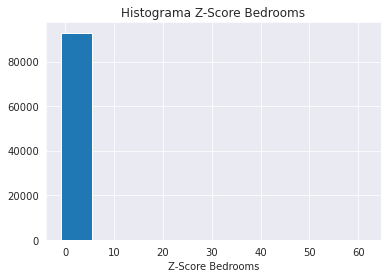

In [125]:
plt.hist(z_bedrooms_ds.z_property_bedrooms)
plt.title('Histograma Z-Score Bedrooms')
plt.xlabel('Z-Score Bedrooms')
plt.show()

##### Superficie Total

In [126]:
z_total_ds = calculate_zscore_st(ds_filtrado, ds_filtrado.property_surface_total)

In [127]:
print(
    f"Los outliers superiores de sup total son: {len(z_total_ds[z_total_ds['z_property_surface_total'] > 3])}. Constituyen al {(len(z_total_ds[z_total_ds['z_property_surface_total'] > 3]) * 100) // len(ds_filtrado.property_surface_total)}% de los datos")
z_total_ds[z_total_ds['z_property_surface_total'] > 3]

Los outliers superiores de sup total son: 70. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_surface_total
33017,UzV402bMqMRezkA/xEyQ1w==,2021-02-08,2021-04-23 10:42:07.845036320,-34.634196,-58.465152,Flores,Venta,Departamento,1.0,1.0,4428.0,31.0,58552.0,Departamento - Flores,5.894459
34113,TOICJnvvamy4J2bHIyfZAQ==,2021-02-08,2021-03-04 00:00:00.000000000,-34.554356,-58.458076,Belgrano,Venta,Departamento,2.0,1.0,2500.0,51.0,189850.0,VENTA DEPARTAMENTO 2 AMBIENTES PISO ALTO BELGRANO,3.267307
34123,Kr2fYXhFuQz9vuxKD2btYw==,2021-02-08,2021-05-01 00:00:00.000000000,-34.557903,-58.452293,Belgrano,Venta,Departamento,4.0,3.0,5000.0,109.0,418000.0,VENTA DEPARTAMENTO 3-4 AMBIENTES COCHERA BELG...,6.673884
34608,g2uthf40imsD2Cuq7jQh6g==,2021-02-08,2021-03-18 00:00:00.000000000,-34.611660,-58.393440,Balvanera,Venta,Departamento,2.0,1.0,2383.0,37.0,64000.0,VENTA HERMOSO 2 AMBIENTES BALVANERA. OPORTUNIDAD,3.107879
35536,5ZqlVB4OQDBy8GSEXpHnqw==,2021-02-08,2021-03-18 00:00:00.000000000,-34.573000,-58.481100,Villa Urquiza,Venta,Departamento,1.0,1.0,3660.0,33.0,98000.0,Venta Depto monoambiente a estrenar villa Urquiza,4.847959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459588,cu+23paFW640od7H6C2iHg==,2021-01-05,2021-01-06 00:00:00.000000000,-34.574650,-58.437659,Belgrano,Venta,Departamento,3.0,2.0,6609.0,60.0,210000.0,DEPARTAMENTO VENTA BELGRANO 3 AMBIENTES 66 M2,8.866357
459841,9aQHQRqWMburSn+z+Qt5aQ==,2021-01-05,2021-01-09 00:00:00.000000000,-34.627876,-58.437996,Caballito,Venta,Departamento,3.0,2.0,7153.0,7153.0,177807.0,3 Ambientes Venta de Pozo Caballito Full Ameni...,9.607628
459842,Y4PuRUaAW17tsLGwFTukhA==,2021-01-05,2021-01-09 00:00:00.000000000,-34.628397,-58.437706,Caballito,Venta,Departamento,3.0,2.0,8136.0,6472.0,203550.0,3 Ambientes Venta de Pozo Caballito Full Ameni...,10.947095
459847,zMligt7YdiayCjrfqlmbfg==,2021-01-05,2021-01-09 00:00:00.000000000,-34.628247,-58.437696,Caballito,Venta,Departamento,4.0,3.0,18096.0,8568.0,324558.0,4 Ambientes Venta de Pozo Caballito Full Ameni...,24.518899


In [128]:
print(
    f"Los outliers inf de sup total son: {len(z_total_ds[z_total_ds['z_property_surface_total'] < -3])}. Constituyen al {(len(z_total_ds[z_total_ds['z_property_surface_total'] < -3]) * 100) // len(ds_filtrado.property_surface_total)}% de los datos")
z_total_ds[z_total_ds['z_property_surface_total'] < -3]

Los outliers inf de sup total son: 0. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_surface_total


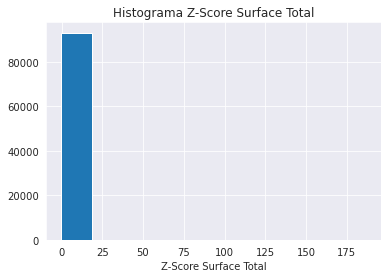

In [129]:
plt.hist(z_total_ds.z_property_surface_total)
plt.title('Histograma Z-Score Surface Total')
plt.xlabel('Z-Score Surface Total')
plt.show()

##### Superficie Cubierta

In [130]:
z_covered_ds = calculate_zscore_st(ds_filtrado, ds_filtrado.property_surface_covered)

In [131]:
print(
    f"Los outliers superiores de sup cubierta son: {len(z_covered_ds[z_covered_ds['z_property_surface_covered'] > 3])}. Constituyen al {(len(z_covered_ds[z_covered_ds['z_property_surface_covered'] > 3]) * 100) // len(ds_filtrado.property_surface_covered)}% de los datos")
z_covered_ds[z_covered_ds['z_property_surface_covered'] > 3]

Los outliers superiores de sup cubierta son: 58. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_surface_covered
23769,dvBGT5V4nYWKZe+jyJm7nA==,2021-05-03,2021-06-05 00:00:00.000000000,-31.362940,-64.569104,NaN,Venta,Casa,3.0,2.0,1000.0,869.0,360000.0,Se Vende casa-Duplex-Galpón Todo Junto o Separado,3.570494
23773,p9e+CYoVqxleN1uhZFSWNQ==,2021-05-03,2021-06-05 00:00:00.000000000,-31.362940,-64.569104,NaN,Venta,Casa,3.0,2.0,1000.0,869.0,360000.0,Se Vende casa-Duplex-Galpón Todo Junto o Separado,3.570494
30359,rpeGyTLDvloNDFf/CSF6Aw==,2021-10-15,2022-01-27 00:00:00.000000000,NaN,NaN,San Telmo,Venta,Departamento,2.0,1.0,48.0,4435.0,93500.0,Dptos 2 amb a estrenar en San Telmo!!!,19.710534
51748,DGUIqrE5dSAcW7/SkUWaQA==,2021-06-23,2021-06-28 00:00:00.000000000,-34.608698,-58.391820,Balvanera,Venta,Departamento,10.0,5.0,1212.0,1212.0,1500000.0,Departamento - Congreso,5.122943
72521,csbBJk04jQXgGZLXTj5WAg==,2021-05-29,2021-06-13 00:00:00.000000000,-34.600113,-58.403649,Balvanera,Venta,Departamento,2.0,1.0,33800.0,31670.0,66000.0,VENTA 2 AMBIENTES CON RENTA,142.978617
78608,ZbpQ//uGbkptlB1M50OlCg==,2021-11-10,2022-01-27 00:00:00.000000000,-34.570078,-58.469164,Belgrano,Venta,Casa,10.0,7.0,1442.0,830.0,1850000.0,MAGNÍFICA RESIDENCIA - 10 AMB - GRAN PARQUE - ...,3.393977
85725,pKJUYwxjs9j+ub8gzLyc/g==,2021-03-26,2021-06-05 00:00:00.000000000,-34.572494,-58.462433,Belgrano,Venta,Casa,5.0,4.0,3197.0,3367.0,12000000.0,Casa - Belgrano R,14.876669
94789,jXPtdq0ibrnXyePLhTi27g==,2021-09-24,2021-09-26 00:00:00.000000000,-34.614279,-58.361092,Caballito,Venta,Departamento,2.0,1.0,5312.0,4809.0,145000.0,VENTA - EMPRENDIMIENTO DEPARTAMENTO 2 AMBIENTES,21.403292
95249,ddJ4UiNHWKHJNJeygYWSFw==,2021-09-24,2022-01-27 00:00:00.000000000,-34.582163,-58.486763,Villa Urquiza,Venta,Departamento,2.0,1.0,883.0,883.0,125000.0,Departamento - Villa Urquiza,3.633859
104177,rGOjA8tJXYsGapcTNwIKQA==,2021-05-28,2021-06-13 00:00:00.000000000,-34.603992,-58.500042,Villa del Parque,Venta,Departamento,1.0,1.0,3623.0,3615.0,110000.0,VENTA MONOAMB VILLA DEL PARQUE CON COCHERA,15.999139


In [132]:
print(
    f"Los outliers inferiores de sup cubierta son: {len(z_covered_ds[z_covered_ds['z_property_surface_covered'] < -3])}. Constituyen al {(len(z_covered_ds[z_covered_ds['z_property_surface_covered'] < -3]) * 100) // len(ds_filtrado.property_surface_covered)}% de los datos")
z_covered_ds[z_covered_ds['z_property_surface_covered'] < -3]

Los outliers inferiores de sup cubierta son: 0. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_surface_covered


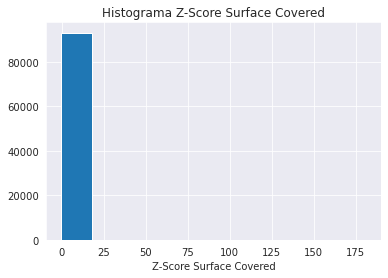

In [133]:
plt.hist(z_covered_ds.z_property_surface_covered)
plt.title('Histograma Z-Score Surface Covered')
plt.xlabel('Z-Score Surface Covered')
plt.show()

##### Latitud y Longitud

In [134]:
z_latitud_ds = calculate_zscore_st(ds_filtrado, ds_filtrado.latitud)

In [135]:
print(
    f"Los outliers superiores de latitud son: {len(z_latitud_ds[z_latitud_ds['z_latitud'] > 3])}. Constituyen al {(len(z_latitud_ds[z_latitud_ds['z_latitud'] > 3]) * 100) // len(ds_filtrado.latitud)}% de los datos")
z_latitud_ds[z_latitud_ds['z_latitud'] > 3]

Los outliers superiores de latitud son: 131. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_latitud
3088,0E8ictkgjcCLl8leFB1Cyw==,2021-02-20,2022-02-09,-31.678900,-63.879640,NaN,Venta,Casa,5.0,4.0,220.0,220.0,230000.0,VENTA HERMOSA CASA 5 AMB. C/PILETA - BOCA RATÓN,16.996454
9153,PGEusvkhHkst1cMhvxu/WA==,2021-05-18,2021-06-23,-33.081030,-68.468140,NaN,Venta,Departamento,3.0,2.0,66.0,60.0,80000.0,Venta 3 ambientes San Martín Centro Gran Balcon,8.817223
9156,pY/8UqUbnzAmyeHnEDPDIQ==,2021-05-18,2021-11-04,-31.390431,-64.179004,NaN,Venta,Departamento,1.0,1.0,38.0,38.0,55000.0,Depto en VENTA 1 dormitorio + cochera - Merlo ...,18.679220
11432,e1sN9lAnHRQoxCCtun7GUA==,2021-07-06,2022-02-09,-33.528049,-64.168459,NaN,Venta,Casa,5.0,4.0,1800.0,280.0,390000.0,Casa en venta Club de campo Las Perdices,6.209568
12962,PxTxkVaOSszP5lWImkFyyw==,2021-03-01,2021-03-01,-27.469213,-58.830635,NaN,Venta,Departamento,2.0,1.0,55.0,55.0,120000.0,Depto Apto Profesional 70mt2 - Microcentro,41.553378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411058,pUcVtnFyfRaD8YhgT/GMEQ==,2021-03-02,2021-06-05,-32.964094,-60.629053,NaN,Venta,Departamento,1.0,1.0,34.0,34.0,52000.0,Departamento MONOAMBIENTE A ESTRENAR contrafre...,9.499362
424020,gs9mOziVxiwQyC/HrVTWNA==,2021-12-16,2022-03-25,-30.436760,-64.317055,NaN,Venta,Casa,6.0,3.0,172.0,112.0,134000.0,Venta Casa en Manzanares Barrio Abierto,24.242394
432801,PsYOo3XoVU9pqQHTtDjg/w==,2021-05-04,2021-09-30,-31.678900,-63.879640,NaN,Venta,Casa,8.0,5.0,507.0,457.0,650000.0,Venta casa en Los Lagartos CC,16.996454
437007,9DGfU3Z1mcIjJLGP6e7egw==,2021-10-27,2022-01-27,-32.138586,-64.501116,NaN,Venta,Casa,5.0,2.0,700.0,75.0,60000.0,Cabaña en venta en El Corcovado,14.314907


In [136]:
print(
    f"Los outliers inferiores de latitud son: {len(z_latitud_ds[z_latitud_ds['z_latitud'] < -3])}. Constituyen al {(len(z_latitud_ds[z_latitud_ds['z_latitud'] < -3]) * 100) // len(ds_filtrado.latitud)}% de los datos")
z_latitud_ds[z_latitud_ds['z_latitud'] < -3]

Los outliers inferiores de latitud son: 11. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_latitud
10486,urWyn9L7ma60VBO8Ru6Xew==,2021-01-13,2021-03-28 10:42:07.845036320,-41.163826,-71.438923,NaN,Venta,Casa,4.0,3.0,100.0,100.0,410000.0,BAJO EL PRECIO!! CASA 4 AMB. EN LA LOMA - CERR...,-38.333220
84653,KU1w9AJsKMjk4HeA2Cy+eQ==,2021-03-26,2021-06-05 00:00:00.000000000,-41.168947,-71.439510,NaN,Venta,Casa,9.0,7.0,250.0,250.0,500000.0,Calida y Exclusiva Propiedad en Villa Catedral,-38.363095
105792,LHDYXTfhEERw7S90k5WA+Q==,2021-03-11,2021-06-05 00:00:00.000000000,-41.084900,-71.187159,NaN,Venta,Departamento,1.0,1.0,53.0,53.0,145000.0,Villa Huapi - Dina Huapi - Río Negro - APTO CR...,-37.872810
106288,Hrs1e9U6zkvjRh6gD/BBoQ==,2021-03-11,2021-06-05 00:00:00.000000000,-40.131723,-71.299436,NaN,Venta,Departamento,2.0,1.0,44.0,44.0,105000.0,"Hermoso departamento en venta, totalmente equi...",-32.312519
106297,oqSIUrrkBRMakJoEW/hYPg==,2021-03-11,2021-06-05 00:00:00.000000000,-41.086352,-71.185720,NaN,Venta,Departamento,2.0,1.0,53.0,53.0,145000.0,POSIBLE PERMUTA-Villa Huapi - Dina Huapi - Río...,-37.881283
131188,Qmi68tFcN9DiyOJjVmGvYg==,2021-05-27,2021-06-05 00:00:00.000000000,-41.083002,-71.182747,NaN,Venta,Departamento,2.0,1.0,66.0,56.0,135000.0,VENDO MUY LINDO DEPARTAMENTO EN COMPLEJO CERRADO,-37.861740
155333,j+0Iyd6D8YGQxE3u+nJiQQ==,2021-04-05,2021-04-15 00:00:00.000000000,-41.164123,-71.415420,NaN,Venta,Casa,3.0,2.0,70.0,70.0,380000.0,"HERMOSO LOTE CON CABAÑA EN BARILOCHE, V. LOS C...",-38.334956
208085,2Xn6RKpg2Fps+wLCsSJavw==,2021-02-01,2021-04-16 10:42:07.845036320,-41.085373,-71.185766,NaN,Venta,Departamento,2.0,1.0,60.0,50.0,142000.0,Excelente departamento en venta en Dina Huapi ...,-37.875574
324200,SSbx+/6MNgxE6rIDYPA0+A==,2021-03-03,2021-06-05 00:00:00.000000000,-38.940227,-68.073865,NaN,Venta,Departamento,3.0,2.0,55.0,55.0,120000.0,DEPTO 2 DORM EN COMPLEJO CALLE LOS LIRIOS BARR...,-25.362007
410404,KeQ40Z6VTXMHoq4j8oOp+A==,2021-03-02,2021-06-05 00:00:00.000000000,-38.964493,-68.075830,NaN,Venta,Casa,7.0,5.0,218.0,218.0,230000.0,CASA 5 DORM BARRIO VILLA FLORENCIA CALLE REMIG...,-25.503563


Comprarandolo con los valores de lat/long del gráfico de CABA, podemos ver que los datos corresponden a valores que no están dentro del rango. Procederemos a eliminarlos en base al zscore.

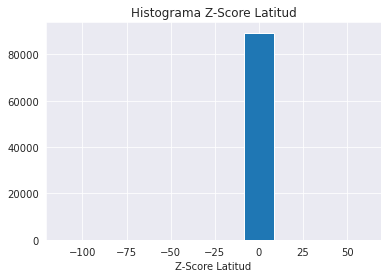

In [137]:
plt.hist(z_latitud_ds.z_latitud)
plt.title('Histograma Z-Score Latitud')
plt.xlabel('Z-Score Latitud')
plt.show()

In [138]:
z_longitud_ds = calculate_zscore_st(ds_filtrado, ds_filtrado.longitud)
z_latitud_ds.head()

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_latitud
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,NaN
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,-0.261282
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,-0.210693
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,-34.610027,-58.401934,Once,Venta,Departamento,4.0,2.0,104.0,104.0,146000.0,Venta departamento 4 ambientes Once,-0.102079
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,-34.631621,-58.416825,Boedo,Venta,PH,4.0,2.0,73.0,73.0,250000.0,PH - Boedo,-0.228043


In [139]:
print(
    f"Los outliers superiores de longitud son: {len(z_longitud_ds[z_longitud_ds['z_longitud'] > 3])}. Constituyen al {(len(z_longitud_ds[z_longitud_ds['z_longitud'] > 3]) * 100) // len(ds_filtrado.longitud)}% de los datos")
z_longitud_ds[z_longitud_ds['z_longitud'] > 3]

Los outliers superiores de longitud son: 7. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_longitud
134196,s3z8Y8u6UYiGamjl7GKWUA==,2021-04-06,2021-04-25,-27.58162,-56.682310,NaN,Venta,Casa,4.0,2.0,105.0,105.0,200000.0,Casa jardín 2 dorm escrit. a 1 cdra Estación,6.253301
173667,NPA86ettFBDIW2fcHGhq9Q==,2021-05-11,2021-05-12,-27.63119,-55.496357,NaN,Venta,Departamento,4.0,3.0,98.0,88.0,269000.0,Venta departamento 4 amb Vicente Lopez con cochea,10.452826
187631,kQaGoFd//JEG6YJEilDGzg==,2021-06-05,2021-08-26,-29.68992,-57.556660,NaN,Venta,Departamento,5.0,4.0,158.0,150.0,380000.0,"5 Ambientes, 4 baños, AMENITIES, Talar de Mart...",3.157179
220851,/4CiKZFK0D3wJRClv4OO8Q==,2021-06-30,2021-07-02,-27.58162,-56.682310,NaN,Venta,Casa,4.0,2.0,105.0,105.0,190000.0,Casa jardín 2 dorm escrit. a 1 cdra Estación,6.253301
234893,FmDOCgqTy/T9iZXvORmyuw==,2021-06-02,2021-06-18,-27.63119,-55.496357,NaN,Venta,Departamento,4.0,3.0,98.0,88.0,269000.0,Venta departamento 4 amb Vicente Lopez con cochea,10.452826
241662,MKUbLxaAzotEHRijSe9a0w==,2021-04-01,2021-04-19,-26.61667,-54.133330,NaN,Venta,Casa,4.0,3.0,230.0,200.0,255000.0,Venta casa barrio cerrado Santa Rita 4 ambie...,15.279380
405382,C7g/npsqWoeBtBCNr0injg==,2021-01-07,2021-01-09,-26.61667,-54.133330,NaN,Venta,Casa,3.0,2.0,205.0,102.0,125000.0,"Depto Venta, Fincas de San Vicente II, 3 amb",15.279380


In [140]:
print(
    f"Los outliers inferiores de longitud son: {len(z_longitud_ds[z_longitud_ds['z_longitud'] < -3])}. Constituyen al {(len(z_longitud_ds[z_longitud_ds['z_longitud'] < -3]) * 100) // len(ds_filtrado.longitud)}% de los datos")
z_longitud_ds[z_longitud_ds['z_longitud'] < -3]

Los outliers inferiores de longitud son: 134. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_longitud
3088,0E8ictkgjcCLl8leFB1Cyw==,2021-02-20,2022-02-09 00:00:00.000000000,-31.678900,-63.879640,NaN,Venta,Casa,5.0,4.0,220.0,220.0,230000.0,VENTA HERMOSA CASA 5 AMB. C/PILETA - BOCA RATÓN,-19.232844
9153,PGEusvkhHkst1cMhvxu/WA==,2021-05-18,2021-06-23 00:00:00.000000000,-33.081030,-68.468140,NaN,Venta,Departamento,3.0,2.0,66.0,60.0,80000.0,Venta 3 ambientes San Martín Centro Gran Balcon,-35.480976
9156,pY/8UqUbnzAmyeHnEDPDIQ==,2021-05-18,2021-11-04 00:00:00.000000000,-31.390431,-64.179004,NaN,Venta,Departamento,1.0,1.0,38.0,38.0,55000.0,Depto en VENTA 1 dormitorio + cochera - Merlo ...,-20.292908
10486,urWyn9L7ma60VBO8Ru6Xew==,2021-01-13,2021-03-28 10:42:07.845036320,-41.163826,-71.438923,NaN,Venta,Casa,4.0,3.0,100.0,100.0,410000.0,BAJO EL PRECIO!! CASA 4 AMB. EN LA LOMA - CERR...,-46.000682
11432,e1sN9lAnHRQoxCCtun7GUA==,2021-07-06,2022-02-09 00:00:00.000000000,-33.528049,-64.168459,NaN,Venta,Casa,5.0,4.0,1800.0,280.0,390000.0,Casa en venta Club de campo Las Perdices,-20.255568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424020,gs9mOziVxiwQyC/HrVTWNA==,2021-12-16,2022-03-25 00:00:00.000000000,-30.436760,-64.317055,NaN,Venta,Casa,6.0,3.0,172.0,112.0,134000.0,Venta Casa en Manzanares Barrio Abierto,-20.781753
432801,PsYOo3XoVU9pqQHTtDjg/w==,2021-05-04,2021-09-30 00:00:00.000000000,-31.678900,-63.879640,NaN,Venta,Casa,8.0,5.0,507.0,457.0,650000.0,Venta casa en Los Lagartos CC,-19.232844
437007,9DGfU3Z1mcIjJLGP6e7egw==,2021-10-27,2022-01-27 00:00:00.000000000,-32.138586,-64.501116,NaN,Venta,Casa,5.0,2.0,700.0,75.0,60000.0,Cabaña en venta en El Corcovado,-21.433525
448128,HRFCaJgDzUO+/lyKG46ZMw==,2021-12-16,2022-02-09 00:00:00.000000000,-33.081030,-68.468140,NaN,Venta,Departamento,1.0,1.0,38.0,38.0,89500.0,DEPTO A ESTR. COCHERA PISCINA PISTA DE ATLETISMO,-35.480976


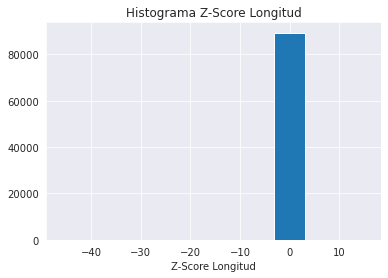

In [141]:
plt.hist(z_longitud_ds.z_longitud)
plt.title('Histograma Z-Score Longitud')
plt.xlabel('Z-Score Longitud')
plt.show()

#### Metodo Z Score modificado

In [142]:
def calculate_modified_zscore_st(dataset, column):
    new_df = dataset.copy()
    mediana = column.median()
    MAD = np.absolute(column - mediana).median()

    new_df[f'zm_{column.name}'] = (column - mediana) * 0.6745 / MAD
    return new_df

##### Ambientes

In [143]:
zm_rooms_ds = calculate_modified_zscore_st(ds_filtrado, ds_filtrado.property_rooms)

Verificamos si se cumple la regla de oro para la variable Rooms en el zscore modificado

In [144]:
print(
    f"Los outliers superiores de rooms son: {len(zm_rooms_ds[zm_rooms_ds['zm_property_rooms'] > 3.5])}. Constituyen al {(len(zm_rooms_ds[zm_rooms_ds['zm_property_rooms'] > 3.5]) * 100) // len(ds_filtrado.property_rooms)}% de los datos")
zm_rooms_ds[zm_rooms_ds['zm_property_rooms'] > 3.5]

Los outliers superiores de rooms son: 381. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_rooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26 00:00:00.000000000,-34.633730,-58.424729,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.7215
834,DW1aOtw9rrmcRJKrXV8lQQ==,2021-09-09,2022-03-09 00:00:00.000000000,-34.586193,-58.396815,Recoleta,Venta,Departamento,9.0,4.0,390.0,340.0,1200000.0,“La Isla”-Gelly Obes-Copérnico-Espectacular pi...,4.0470
1769,g1hq2MUtnOPGU2VYSr2BWw==,2021-12-17,2022-01-27 00:00:00.000000000,-34.623581,-58.484051,Floresta,Venta,Casa,10.0,6.0,240.0,240.0,320000.0,Casa - Floresta,4.7215
3071,r6wObBTHokmjYtHqvcAlyQ==,2021-02-20,2021-03-01 00:00:00.000000000,-34.623590,-58.401566,San Cristobal,Venta,PH,15.0,15.0,355.0,215.0,220000.0,PH 15 AMBIENTES HOTEL A RECICLAR San Cristóbal,8.0940
6279,Ouq4jrslx03LUpqpoVwuTg==,2021-10-29,2022-01-27 00:00:00.000000000,-34.593211,-58.390512,Recoleta,Venta,Departamento,10.0,5.0,600.0,600.0,2000000.0,PISO VIVIENDA APTO PROF EN RECOLETA LAS HERAS...,4.7215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451439,xAhwsSTSgi3S3LwevVCiLA==,2021-12-16,2021-12-21 00:00:00.000000000,-34.609154,-58.383631,Congreso,Venta,Departamento,10.0,9.0,240.0,227.0,370000.0,Venta 10 amb - Congreso - Edificio Historico A...,4.7215
453847,NTZQ7bMIl4KrSNE/Yna15A==,2021-12-16,2022-02-09 00:00:00.000000000,-34.635489,-58.502057,Villa Luro,Venta,Casa,10.0,4.0,235.0,200.0,224000.0,¡Venta Única! Casa en Villa Luro Patio y Terraza,4.7215
457782,zThHFYUg/ZODnN9ekjwgFg==,2021-05-08,2021-06-05 00:00:00.000000000,-34.581524,-58.403588,Palermo,Venta,Departamento,10.0,6.0,520.0,500.0,3300000.0,Venta Departamento Palermo,4.7215
458873,JklH0r8XBsFn3380WryLIw==,2021-01-05,2021-03-20 10:42:07.845036320,-34.625353,-58.372014,San Telmo,Venta,Casa,12.0,12.0,820.0,820.0,550000.0,Casa de 820 m2 en San Telmo,6.0705


In [145]:
print(
    f"Los outliers inferiores de rooms son: {len(zm_rooms_ds[zm_rooms_ds['zm_property_rooms'] < -3.5])}. Constituyen al {(len(zm_rooms_ds[zm_rooms_ds['zm_property_rooms'] < -3.5]) * 100) // len(ds_filtrado.property_rooms)}% de los datos")
zm_rooms_ds[zm_rooms_ds['zm_property_rooms'] < -3.5]

Los outliers inferiores de rooms son: 0. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_rooms


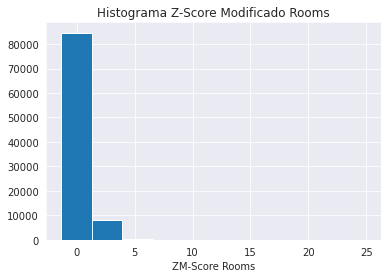

In [146]:
plt.hist(zm_rooms_ds.zm_property_rooms)
plt.title('Histograma Z-Score Modificado Rooms')
plt.xlabel('ZM-Score Rooms')
plt.show()

##### Habitaciones

In [147]:
zm_bedrooms_ds = calculate_modified_zscore_st(ds_filtrado, ds_filtrado.property_bedrooms)
zm_bedrooms_ds.head()

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_bedrooms
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,0.6745
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,0.0000
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,0.6745
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,-34.610027,-58.401934,Once,Venta,Departamento,4.0,2.0,104.0,104.0,146000.0,Venta departamento 4 ambientes Once,0.0000
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,-34.631621,-58.416825,Boedo,Venta,PH,4.0,2.0,73.0,73.0,250000.0,PH - Boedo,0.0000


In [148]:
print(
    f"Los outliers superiores de bedrooms son: {len(zm_bedrooms_ds[zm_bedrooms_ds['zm_property_bedrooms'] > 3.5])}. Constituyen al {(len(zm_bedrooms_ds[zm_bedrooms_ds['zm_property_bedrooms'] > 3.5]) * 100) // len(ds_filtrado.property_bedrooms)}% de los datos")
zm_bedrooms_ds[zm_bedrooms_ds['zm_property_bedrooms'] > 3.5]

Los outliers superiores de bedrooms son: 161. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_bedrooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26 00:00:00.000000000,-34.633730,-58.424729,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,5.3960
3071,r6wObBTHokmjYtHqvcAlyQ==,2021-02-20,2021-03-01 00:00:00.000000000,-34.623590,-58.401566,San Cristobal,Venta,PH,15.0,15.0,355.0,215.0,220000.0,PH 15 AMBIENTES HOTEL A RECICLAR San Cristóbal,8.7685
6355,PZJRORTIAvMTvI3A+FLDUQ==,2021-10-29,2021-11-03 00:00:00.000000000,-34.577180,-58.451264,Colegiales,Venta,Departamento,6.0,8.0,424.0,324.0,660000.0,DEPARTAMENTOS CON 2 UNIDADES COMPLEMENTARIAS E...,4.0470
15418,JotqKLYZWWG/uHiM6+CThA==,2021-04-22,2021-04-25 00:00:00.000000000,-34.620137,-58.374386,San Telmo,Venta,PH,12.0,12.0,688.0,350.0,600000.0,"PH sin expensas!!, con gran patio y terraza pr...",6.7450
15902,9pmQFoGdVAJyjBiQo2f0wg==,2021-06-10,2021-11-13 00:00:00.000000000,-34.639283,-58.451543,Flores,Venta,PH,11.0,8.0,467.0,257.0,299000.0,Venta en bloque de 4 PH - Lote de 8.66x50 - Id...,4.0470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438314,niN7qH7fPC5WZf1e/w5VgA==,2021-04-23,2021-06-05 00:00:00.000000000,-34.624766,-58.418918,Boedo,Venta,PH,20.0,14.0,1019.0,1019.0,820000.0,Edificio ubicado en el Barrio de Boedo en Vent...,8.0940
449070,rBF+6yKQXe/+8WAhVElKjg==,2021-12-16,2022-03-25 00:00:00.000000000,-34.629306,-58.465354,Flores,Venta,Departamento,8.0,8.0,275.0,275.0,219000.0,Piso 275 m2 Rivadavia y Varela,4.0470
451439,xAhwsSTSgi3S3LwevVCiLA==,2021-12-16,2021-12-21 00:00:00.000000000,-34.609154,-58.383631,Congreso,Venta,Departamento,10.0,9.0,240.0,227.0,370000.0,Venta 10 amb - Congreso - Edificio Historico A...,4.7215
458873,JklH0r8XBsFn3380WryLIw==,2021-01-05,2021-03-20 10:42:07.845036320,-34.625353,-58.372014,San Telmo,Venta,Casa,12.0,12.0,820.0,820.0,550000.0,Casa de 820 m2 en San Telmo,6.7450


In [149]:
print(
    f"Los outliers inferiores de bedrooms son: {len(zm_bedrooms_ds[zm_bedrooms_ds['zm_property_bedrooms'] < -3.5])}. Constituyen al {(len(zm_bedrooms_ds[zm_bedrooms_ds['zm_property_bedrooms'] < -3.5]) * 100) // len(ds_filtrado.property_bedrooms)}% de los datos")
zm_bedrooms_ds[zm_bedrooms_ds['zm_property_bedrooms'] < -3.5]

Los outliers inferiores de bedrooms son: 0. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_bedrooms


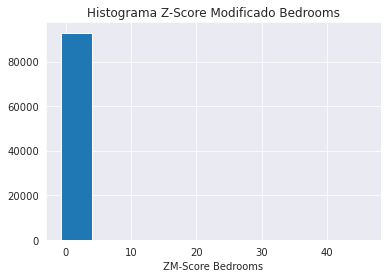

In [150]:
plt.hist(zm_bedrooms_ds.zm_property_bedrooms)
plt.title('Histograma Z-Score Modificado Bedrooms')
plt.xlabel('ZM-Score Bedrooms')
plt.show()

##### Superficie Total

In [151]:
zm_total_ds = calculate_modified_zscore_st(ds_filtrado, ds_filtrado.property_surface_total)
zm_total_ds.head()

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_surface_total
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,2.979042
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,-0.196729
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,0.140521
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,-34.610027,-58.401934,Once,Venta,Departamento,4.0,2.0,104.0,104.0,146000.0,Venta departamento 4 ambientes Once,1.096062
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,-34.631621,-58.416825,Boedo,Venta,PH,4.0,2.0,73.0,73.0,250000.0,PH - Boedo,0.224833


Verificamos si se cumple la regla de oro para la variable sup total en el zscore modificado

In [152]:
print(
    f"Los outliers superiores de sup total son: {len(zm_total_ds[zm_total_ds['zm_property_surface_total'] > 3.5])}. Constituyen al {(len(zm_total_ds[zm_total_ds['zm_property_surface_total'] > 3.5]) * 100) // len(ds_filtrado.property_surface_total)}% de los datos")
zm_total_ds[zm_total_ds['zm_property_surface_total'] > 3.5]

Los outliers superiores de sup total son: 7877. Constituyen al 8% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_surface_total
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,-34.633730,-58.424729,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,9.246271
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,-34.575053,-58.407958,Palermo,Venta,Departamento,4.0,3.0,282.0,256.0,2250000.0,Torre Vignoli 282 metros . 3 suites . 2 cocheras,6.098604
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,-34.577855,-58.408796,Palermo,Venta,Departamento,5.0,4.0,304.0,294.0,1200000.0,Departamento de 5 ambientes con dependencia -...,6.716896
629,1Q/fC60k0cGKYTu6hUqf1g==,2021-09-09,2021-09-11,-34.566536,-58.448246,Belgrano,Venta,Departamento,4.0,3.0,214.0,196.0,1200000.0,Departamento - Belgrano,4.187521
653,k3FuLeIEFq9KJotylsHl1Q==,2021-09-09,2022-02-09,-34.567191,-58.458145,Belgrano,Venta,Departamento,4.0,3.0,226.0,94.0,345000.0,Venta Semipiso 4amb Patio y Cochera - Belgrano,4.524771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459841,9aQHQRqWMburSn+z+Qt5aQ==,2021-01-05,2021-01-09,-34.627876,-58.437996,Caballito,Venta,Departamento,3.0,2.0,7153.0,7153.0,177807.0,3 Ambientes Venta de Pozo Caballito Full Ameni...,199.202333
459842,Y4PuRUaAW17tsLGwFTukhA==,2021-01-05,2021-01-09,-34.628397,-58.437706,Caballito,Venta,Departamento,3.0,2.0,8136.0,6472.0,203550.0,3 Ambientes Venta de Pozo Caballito Full Ameni...,226.828729
459847,zMligt7YdiayCjrfqlmbfg==,2021-01-05,2021-01-09,-34.628247,-58.437696,Caballito,Venta,Departamento,4.0,3.0,18096.0,8568.0,324558.0,4 Ambientes Venta de Pozo Caballito Full Ameni...,506.746229
459849,+9w0GBZbuObF0Nw6AAtu2Q==,2021-01-05,2021-01-09,-34.628282,-58.437803,Caballito,Venta,Departamento,3.0,2.0,7720.0,5970.0,167894.0,3 Ambientes Venta de Pozo Caballito Full Ameni...,215.137396


In [153]:
print(
    f"Los outliers inferiores de sup total son: {len(zm_total_ds[zm_total_ds['zm_property_surface_total'] < -3.5])}. Constituyen al {(len(zm_total_ds[zm_total_ds['zm_property_surface_total'] < -3.5]) * 100) // len(ds_filtrado.property_surface_total)}% de los datos")
zm_total_ds[zm_total_ds['zm_property_surface_total'] < -3.5]

Los outliers inferiores de sup total son: 0. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_surface_total


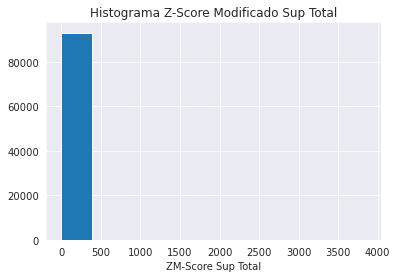

In [154]:
plt.hist(zm_total_ds.zm_property_surface_total)
plt.title('Histograma Z-Score Modificado Sup Total')
plt.xlabel('ZM-Score Sup Total')
plt.show()

##### Superficie Cubierta

In [155]:
zm_covered_ds = calculate_modified_zscore_st(ds_filtrado, ds_filtrado.property_surface_covered)

Verificamos si se cumple la regla de oro para la variable sup cubierta en el zscore modificado

In [156]:
print(
    f"Los outliers superiores de sup cubierta son: {(len(zm_covered_ds[zm_covered_ds['zm_property_surface_covered'] > 3.5]) * 100) // len(ds_filtrado.property_surface_covered)}% de los datos")
zm_covered_ds[zm_covered_ds['zm_property_surface_covered'] > 3.5]

Los outliers superiores de sup cubierta son: 8% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_surface_covered
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26 00:00:00.000000000,-34.633730,-58.424729,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,6.272850
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06 00:00:00.000000000,-34.575053,-58.407958,Palermo,Venta,Departamento,4.0,3.0,282.0,256.0,2250000.0,Torre Vignoli 282 metros . 3 suites . 2 cocheras,6.677550
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27 00:00:00.000000000,-34.577855,-58.408796,Palermo,Venta,Departamento,5.0,4.0,304.0,294.0,1200000.0,Departamento de 5 ambientes con dependencia -...,7.959100
463,ujMVUbCEkvGVq7zpdfk0xQ==,2021-09-09,2021-09-14 00:00:00.000000000,NaN,NaN,Palermo,Venta,Departamento,3.0,2.0,185.0,185.0,890000.0,Espectacular Loft 185 m2 en Venta en Palacio A...,4.283075
629,1Q/fC60k0cGKYTu6hUqf1g==,2021-09-09,2021-09-11 00:00:00.000000000,-34.566536,-58.448246,Belgrano,Venta,Departamento,4.0,3.0,214.0,196.0,1200000.0,Departamento - Belgrano,4.654050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459842,Y4PuRUaAW17tsLGwFTukhA==,2021-01-05,2021-01-09 00:00:00.000000000,-34.628397,-58.437706,Caballito,Venta,Departamento,3.0,2.0,8136.0,6472.0,203550.0,3 Ambientes Venta de Pozo Caballito Full Ameni...,216.312150
459847,zMligt7YdiayCjrfqlmbfg==,2021-01-05,2021-01-09 00:00:00.000000000,-34.628247,-58.437696,Caballito,Venta,Departamento,4.0,3.0,18096.0,8568.0,324558.0,4 Ambientes Venta de Pozo Caballito Full Ameni...,286.999750
459849,+9w0GBZbuObF0Nw6AAtu2Q==,2021-01-05,2021-01-09 00:00:00.000000000,-34.628282,-58.437803,Caballito,Venta,Departamento,3.0,2.0,7720.0,5970.0,167894.0,3 Ambientes Venta de Pozo Caballito Full Ameni...,199.382200
459986,Pxz0dKZgWiL7odLclgK/vA==,2021-01-05,2021-03-20 10:42:07.845036320,-34.613000,-58.362117,Puerto Madero,Venta,Departamento,3.0,2.0,176.0,163.0,790000.0,Departamento en venta en Puerto Madero,3.541125


In [157]:
print(
    f"Los outliers inferiores de sup cubierta son: {len(zm_covered_ds[zm_covered_ds['zm_property_surface_covered'] < -3.5])}. Constituyen al {(len(zm_covered_ds[zm_covered_ds['zm_property_surface_covered'] < -3.5]) * 100) // len(ds_filtrado.property_surface_covered)}% de los datos")
zm_covered_ds[zm_covered_ds['zm_property_surface_covered'] < -3.5]

Los outliers inferiores de sup cubierta son: 0. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_property_surface_covered


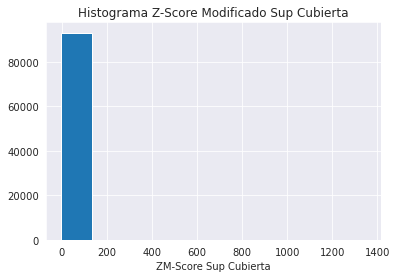

In [158]:
plt.hist(zm_covered_ds.zm_property_surface_covered)
plt.title('Histograma Z-Score Modificado Sup Cubierta')
plt.xlabel('ZM-Score Sup Cubierta')
plt.show()

##### Latitud y longitud

In [159]:
zm_latitud_ds = calculate_modified_zscore_st(ds_filtrado, ds_filtrado.latitud)

Verificamos si se cumple la regla de oro para la variable latitud en el zscore modificado

In [160]:
print(
    f"Los outliers superiores de latitud son: {(len(zm_latitud_ds[zm_latitud_ds['zm_latitud'] > 3.5]) * 100) // len(ds_filtrado.latitud)}% de los datos")
zm_latitud_ds[zm_latitud_ds['zm_latitud'] > 3.5]

Los outliers superiores de latitud son: 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_latitud
3088,0E8ictkgjcCLl8leFB1Cyw==,2021-02-20,2022-02-09,-31.678900,-63.879640,NaN,Venta,Casa,5.0,4.0,220.0,220.0,230000.0,VENTA HERMOSA CASA 5 AMB. C/PILETA - BOCA RATÓN,102.369194
9153,PGEusvkhHkst1cMhvxu/WA==,2021-05-18,2021-06-23,-33.081030,-68.468140,NaN,Venta,Departamento,3.0,2.0,66.0,60.0,80000.0,Venta 3 ambientes San Martín Centro Gran Balcon,53.160771
9156,pY/8UqUbnzAmyeHnEDPDIQ==,2021-05-18,2021-11-04,-31.390431,-64.179004,NaN,Venta,Departamento,1.0,1.0,38.0,38.0,55000.0,Depto en VENTA 1 dormitorio + cochera - Merlo ...,112.493158
11432,e1sN9lAnHRQoxCCtun7GUA==,2021-07-06,2022-02-09,-33.528049,-64.168459,NaN,Venta,Casa,5.0,4.0,1800.0,280.0,390000.0,Casa en venta Club de campo Las Perdices,37.472425
12962,PxTxkVaOSszP5lWImkFyyw==,2021-03-01,2021-03-01,-27.469213,-58.830635,NaN,Venta,Departamento,2.0,1.0,55.0,55.0,120000.0,Depto Apto Profesional 70mt2 - Microcentro,250.110170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411058,pUcVtnFyfRaD8YhgT/GMEQ==,2021-03-02,2021-06-05,-32.964094,-60.629053,NaN,Venta,Departamento,1.0,1.0,34.0,34.0,52000.0,Departamento MONOAMBIENTE A ESTRENAR contrafre...,57.264699
424020,gs9mOziVxiwQyC/HrVTWNA==,2021-12-16,2022-03-25,-30.436760,-64.317055,NaN,Venta,Casa,6.0,3.0,172.0,112.0,134000.0,Venta Casa en Manzanares Barrio Abierto,145.962690
432801,PsYOo3XoVU9pqQHTtDjg/w==,2021-05-04,2021-09-30,-31.678900,-63.879640,NaN,Venta,Casa,8.0,5.0,507.0,457.0,650000.0,Venta casa en Los Lagartos CC,102.369194
437007,9DGfU3Z1mcIjJLGP6e7egw==,2021-10-27,2022-01-27,-32.138586,-64.501116,NaN,Venta,Casa,5.0,2.0,700.0,75.0,60000.0,Cabaña en venta en El Corcovado,86.236297


In [161]:
print(
    f"Los outliers inferiores de sup cubierta son: {len(zm_latitud_ds[zm_latitud_ds['zm_latitud'] < -3.5])}. Constituyen al {(len(zm_latitud_ds[zm_latitud_ds['zm_latitud'] < -3.5]) * 100) // len(ds_filtrado.latitud)}% de los datos")
zm_latitud_ds[zm_latitud_ds['zm_latitud'] < -3.5]

Los outliers inferiores de sup cubierta son: 16. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_latitud
10486,urWyn9L7ma60VBO8Ru6Xew==,2021-01-13,2021-03-28 10:42:07.845036320,-41.163826,-71.438923,NaN,Venta,Casa,4.0,3.0,100.0,100.0,410000.0,BAJO EL PRECIO!! CASA 4 AMB. EN LA LOMA - CERR...,-230.508811
65844,0tGMaOsXgkOAnx8GSH1pmA==,2021-05-15,2021-05-25 00:00:00.000000000,-34.698989,-58.469994,Villa Riachuelo,Venta,Departamento,4.0,3.0,91.0,79.0,59900.0,Venta 3/4 ambientes Vista Abierta Luminoso,-3.622275
82540,j0CggSFoqC9J+F1N9h91wg==,2021-03-12,2021-03-13 00:00:00.000000000,-34.698989,-58.469994,Villa Riachuelo,Venta,Departamento,4.0,3.0,91.0,79.0,65000.0,Venta 3/4 ambientes Vista Abierta Luminoso,-3.622275
84653,KU1w9AJsKMjk4HeA2Cy+eQ==,2021-03-26,2021-06-05 00:00:00.000000000,-41.168947,-71.439510,NaN,Venta,Casa,9.0,7.0,250.0,250.0,500000.0,Calida y Exclusiva Propiedad en Villa Catedral,-230.688549
105792,LHDYXTfhEERw7S90k5WA+Q==,2021-03-11,2021-06-05 00:00:00.000000000,-41.084900,-71.187159,NaN,Venta,Departamento,1.0,1.0,53.0,53.0,145000.0,Villa Huapi - Dina Huapi - Río Negro - APTO CR...,-227.738864
106288,Hrs1e9U6zkvjRh6gD/BBoQ==,2021-03-11,2021-06-05 00:00:00.000000000,-40.131723,-71.299436,NaN,Venta,Departamento,2.0,1.0,44.0,44.0,105000.0,"Hermoso departamento en venta, totalmente equi...",-194.286675
106297,oqSIUrrkBRMakJoEW/hYPg==,2021-03-11,2021-06-05 00:00:00.000000000,-41.086352,-71.185720,NaN,Venta,Departamento,2.0,1.0,53.0,53.0,145000.0,POSIBLE PERMUTA-Villa Huapi - Dina Huapi - Río...,-227.789842
131188,Qmi68tFcN9DiyOJjVmGvYg==,2021-05-27,2021-06-05 00:00:00.000000000,-41.083002,-71.182747,NaN,Venta,Departamento,2.0,1.0,66.0,56.0,135000.0,VENDO MUY LINDO DEPARTAMENTO EN COMPLEJO CERRADO,-227.672265
155333,j+0Iyd6D8YGQxE3u+nJiQQ==,2021-04-05,2021-04-15 00:00:00.000000000,-41.164123,-71.415420,NaN,Venta,Casa,3.0,2.0,70.0,70.0,380000.0,"HERMOSO LOTE CON CABAÑA EN BARILOCHE, V. LOS C...",-230.519258
208085,2Xn6RKpg2Fps+wLCsSJavw==,2021-02-01,2021-04-16 10:42:07.845036320,-41.085373,-71.185766,NaN,Venta,Departamento,2.0,1.0,60.0,50.0,142000.0,Excelente departamento en venta en Dina Huapi ...,-227.755493


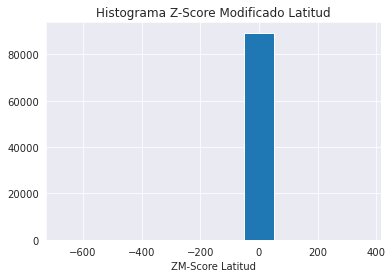

In [162]:
plt.hist(zm_latitud_ds.zm_latitud)
plt.title('Histograma Z-Score Modificado Latitud')
plt.xlabel('ZM-Score Latitud')
plt.show()

In [163]:
zm_longitud_ds = calculate_modified_zscore_st(ds_filtrado, ds_filtrado.longitud)

Verificamos si se cumple la regla de oro para la variable longitud en el zscore modificado

In [164]:
print(
    f"Los outliers superiores de longitud son: {(len(zm_longitud_ds[zm_longitud_ds['zm_longitud'] > 3.5]) * 100) // len(zm_longitud_ds.longitud)}% de los datos")
zm_longitud_ds[zm_longitud_ds['zm_longitud'] > 3.5]

Los outliers superiores de longitud son: 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_longitud
134196,s3z8Y8u6UYiGamjl7GKWUA==,2021-04-06,2021-04-25,-27.58162,-56.682310,NaN,Venta,Casa,4.0,2.0,105.0,105.0,200000.0,Casa jardín 2 dorm escrit. a 1 cdra Estación,41.403229
173667,NPA86ettFBDIW2fcHGhq9Q==,2021-05-11,2021-05-12,-27.63119,-55.496357,NaN,Venta,Departamento,4.0,3.0,98.0,88.0,269000.0,Venta departamento 4 amb Vicente Lopez con cochea,69.355714
187631,kQaGoFd//JEG6YJEilDGzg==,2021-06-05,2021-08-26,-29.68992,-57.556660,NaN,Venta,Departamento,5.0,4.0,158.0,150.0,380000.0,"5 Ambientes, 4 baños, AMENITIES, Talar de Mart...",20.795114
220851,/4CiKZFK0D3wJRClv4OO8Q==,2021-06-30,2021-07-02,-27.58162,-56.682310,NaN,Venta,Casa,4.0,2.0,105.0,105.0,190000.0,Casa jardín 2 dorm escrit. a 1 cdra Estación,41.403229
234893,FmDOCgqTy/T9iZXvORmyuw==,2021-06-02,2021-06-18,-27.63119,-55.496357,NaN,Venta,Departamento,4.0,3.0,98.0,88.0,269000.0,Venta departamento 4 amb Vicente Lopez con cochea,69.355714
241662,MKUbLxaAzotEHRijSe9a0w==,2021-04-01,2021-04-19,-26.61667,-54.133330,NaN,Venta,Casa,4.0,3.0,230.0,200.0,255000.0,Venta casa barrio cerrado Santa Rita 4 ambie...,101.481770
405382,C7g/npsqWoeBtBCNr0injg==,2021-01-07,2021-01-09,-26.61667,-54.133330,NaN,Venta,Casa,3.0,2.0,205.0,102.0,125000.0,"Depto Venta, Fincas de San Vicente II, 3 amb",101.481770


In [165]:
print(
    f"Los outliers inferiores de longitud son: {len(zm_longitud_ds[zm_longitud_ds['zm_longitud'] < -3.5])}. Constituyen al {(len(zm_longitud_ds[zm_longitud_ds['zm_longitud'] < -3.5]) * 100) // len(ds_filtrado.longitud)}% de los datos")
zm_longitud_ds[zm_longitud_ds['zm_longitud'] < -3.5]

Los outliers inferiores de longitud son: 137. Constituyen al 0% de los datos


,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,zm_longitud
3088,0E8ictkgjcCLl8leFB1Cyw==,2021-02-20,2022-02-09 00:00:00.000000000,-31.678900,-63.879640,NaN,Venta,Casa,5.0,4.0,220.0,220.0,230000.0,VENTA HERMOSA CASA 5 AMB. C/PILETA - BOCA RATÓN,-128.235249
9153,PGEusvkhHkst1cMhvxu/WA==,2021-05-18,2021-06-23 00:00:00.000000000,-33.081030,-68.468140,NaN,Venta,Departamento,3.0,2.0,66.0,60.0,80000.0,Venta 3 ambientes San Martín Centro Gran Balcon,-236.384543
9156,pY/8UqUbnzAmyeHnEDPDIQ==,2021-05-18,2021-11-04 00:00:00.000000000,-31.390431,-64.179004,NaN,Venta,Departamento,1.0,1.0,38.0,38.0,55000.0,Depto en VENTA 1 dormitorio + cochera - Merlo ...,-135.291153
10486,urWyn9L7ma60VBO8Ru6Xew==,2021-01-13,2021-03-28 10:42:07.845036320,-41.163826,-71.438923,NaN,Venta,Casa,4.0,3.0,100.0,100.0,410000.0,BAJO EL PRECIO!! CASA 4 AMB. EN LA LOMA - CERR...,-306.404820
11432,e1sN9lAnHRQoxCCtun7GUA==,2021-07-06,2022-02-09 00:00:00.000000000,-33.528049,-64.168459,NaN,Venta,Casa,5.0,4.0,1800.0,280.0,390000.0,Casa en venta Club de campo Las Perdices,-135.042609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424020,gs9mOziVxiwQyC/HrVTWNA==,2021-12-16,2022-03-25 00:00:00.000000000,-30.436760,-64.317055,NaN,Venta,Casa,6.0,3.0,172.0,112.0,134000.0,Venta Casa en Manzanares Barrio Abierto,-138.544957
432801,PsYOo3XoVU9pqQHTtDjg/w==,2021-05-04,2021-09-30 00:00:00.000000000,-31.678900,-63.879640,NaN,Venta,Casa,8.0,5.0,507.0,457.0,650000.0,Venta casa en Los Lagartos CC,-128.235249
437007,9DGfU3Z1mcIjJLGP6e7egw==,2021-10-27,2022-01-27 00:00:00.000000000,-32.138586,-64.501116,NaN,Venta,Casa,5.0,2.0,700.0,75.0,60000.0,Cabaña en venta en El Corcovado,-142.883218
448128,HRFCaJgDzUO+/lyKG46ZMw==,2021-12-16,2022-02-09 00:00:00.000000000,-33.081030,-68.468140,NaN,Venta,Departamento,1.0,1.0,38.0,38.0,89500.0,DEPTO A ESTR. COCHERA PISCINA PISTA DE ATLETISMO,-236.384543


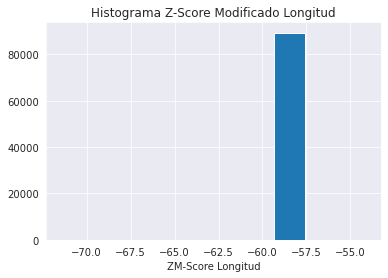

In [166]:
plt.hist(zm_longitud_ds.longitud)
plt.title('Histograma Z-Score Modificado Longitud')
plt.xlabel('ZM-Score Longitud')
plt.show()

### Multivariados

#### Clustering - Mahalanobis

In [201]:
def calculate_mahalanobis_distance(dataset, col1, col2):
    X = dataset[[f'{col1}', f'{col2}']].copy()
    sample_X = X.sample(frac=0.1)

    mu = sample_X.mean()
    X_diff = X - mu
    X_diff = X_diff.values.T

    cov = np.cov(sample_X.values.T)
    inv_cov = np.linalg.inv(cov)
    W = sc.linalg.sqrtm(inv_cov)

    Wx = np.matmul(W, X_diff)
    X['mahalanobis'] = [np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])]

    return X


In [168]:
def create_scatter_plot(dataset, col1, col2):
    #Scatter Plot
    plt.scatter(dataset[col1], dataset[col2])
    plt.title(f'Dispersograma {col1} vs {col2}')
    plt.xlabel(f'{col1}')
    plt.ylabel(f'{col2}')
    plt.show()

In [239]:
def create_scattergram(dataset, col1, col2, outlier_limit):
    #Grafico scatter
    es_outlier = (dataset['mahalanobis'] > outlier_limit)

    sns.scatterplot(x=dataset[col1], y=dataset[col2], hue=es_outlier)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
    plt.title(f'Dispersograma {col1} vs {col2}')
    plt.show()

Analisis entre ambientes y habitaciones de valores atipicos por el metodo de mahalanobis - multivariado

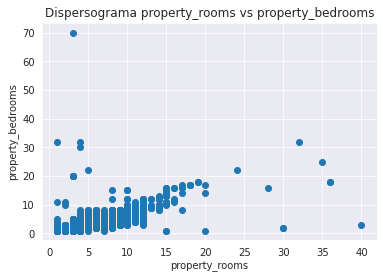

In [203]:
create_scatter_plot(ds_filtrado, 'property_rooms', 'property_bedrooms')

Parecerían exisitir algunas observaciones anómalas. Vamos a calcular la distancia de mahalanobis para cada observación.

In [202]:
mahalanobis_rooms_bedrooms = calculate_mahalanobis_distance(ds_filtrado, 'property_rooms', 'property_bedrooms')
mahalanobis_rooms_bedrooms

,property_rooms,property_bedrooms,mahalanobis
25,4.0,3.0,0.987064
42,3.0,2.0,0.018112
43,4.0,3.0,0.987064
49,4.0,2.0,2.688313
51,4.0,2.0,2.688313
...,...,...,...
460072,4.0,3.0,0.987064
460073,3.0,2.0,0.018112
460074,1.0,1.0,2.237779
460075,1.0,1.0,2.237779


Tenemos que seleccionar un valor umbral para definir qué observaciones podrían ser anómalas según la distancia de mahalanobis.

<AxesSubplot:ylabel='mahalanobis'>

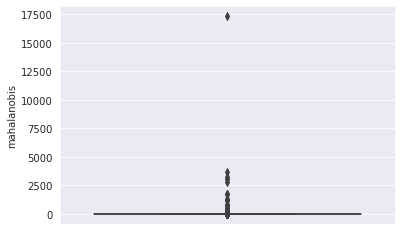

In [204]:
sns.boxplot(y=mahalanobis_rooms_bedrooms.mahalanobis)

Seleccionamos 1000 como valor umbral

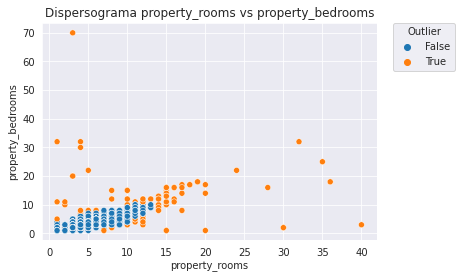

Los outliers para mahalanobis con un umbral de 60 son: 116. Constituyen el 0% de los datos


In [252]:
umbral = 60
create_scattergram(mahalanobis_rooms_bedrooms, 'property_rooms', 'property_bedrooms', umbral)

print(
    f"Los outliers para mahalanobis con un umbral de {umbral} son: {len(mahalanobis_rooms_bedrooms[mahalanobis_rooms_bedrooms['mahalanobis'] > umbral])}. Constituyen el {(len(mahalanobis_rooms_bedrooms[mahalanobis_rooms_bedrooms['mahalanobis'] > umbral]) * 100) // len(ds_filtrado)}% de los datos")

<AxesSubplot:ylabel='mahalanobis'>

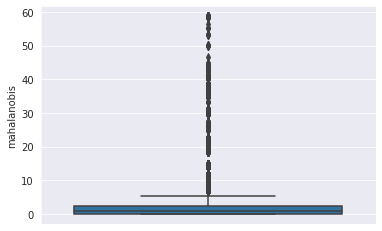

In [248]:
sns.boxplot(y=mahalanobis_rooms_bedrooms[mahalanobis_rooms_bedrooms['mahalanobis'] < umbral].mahalanobis)

In [249]:
mahalanobis_rooms_bedrooms[mahalanobis_rooms_bedrooms['mahalanobis'] > umbral]

,property_rooms,property_bedrooms,mahalanobis
58,10.0,10.0,61.658408
3071,15.0,15.0,153.990919
6355,6.0,8.0,61.396419
9661,12.0,5.0,84.843779
15418,12.0,12.0,93.506751
...,...,...,...
428691,4.0,8.0,105.053670
435163,12.0,4.0,113.625638
436374,15.0,1.0,410.173174
438314,20.0,14.0,151.064452


Como podemos observar en el scatter plot, quedan bien marcados los outliers que en nuestro dominio de problema no tienen ningun sentido.
Por ejemplo, tenemos viviendas con 20 ó 30 ambientes que solo tienen 2 y 3 habitaciones cada una.

In [255]:
#Eliminación de outlier por ínidce de fila
indice_outlier = mahalanobis_rooms_bedrooms[mahalanobis_rooms_bedrooms['mahalanobis'] > umbral].index
ds_filtrado.drop(indice_outlier, inplace=True)
print(
    f"Los outliers de bedrooms post eliminacion son: {len(ds_filtrado[ds_filtrado['mahalanobis'] > umbral])}")

KeyError: '[58, 3071, 6355, 9661, 15418, 21009, 25115, 27849, 31589, 32758, 34828, 36421, 41088, 46931, 48279, 49960, 52157, 52396, 52492, 65039, 70959, 77934, 84296, 86014, 88997, 90004, 90686, 94822, 94998, 97734, 103915, 107554, 107594, 107977, 115403, 118501, 121437, 122371, 122415, 130208, 131217, 140832, 147642, 147750, 147916, 147918, 148313, 149955, 150885, 150987, 152940, 153687, 154467, 173300, 178282, 183941, 199652, 208593, 209620, 211468, 225809, 237737, 239284, 248285, 256054, 257546, 264870, 285221, 285222, 286641, 291391, 292167, 297526, 301399, 304227, 307211, 312668, 318264, 323349, 323350, 327198, 332857, 334144, 337147, 337149, 337831, 340427, 343791, 344509, 346602, 350845, 354668, 356618, 357373, 360045, 362676, 362696, 366101, 367648, 371576, 376551, 389009, 389282, 395077, 396876, 402448, 402516, 405597, 411229, 418413, 421250, 428691, 435163, 436374, 438314, 458873] not found in axis'

Dispersograma post eliminacion de outliers


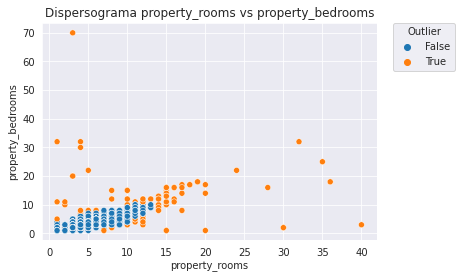

In [258]:
print(f"Dispersograma post eliminacion de outliers")
create_scattergram(mahalanobis_rooms_bedrooms, 'property_rooms', 'property_bedrooms', umbral)

Analisis entre superficie total y superificie cubierta de valores atipicos por el metodo de mahalanobis - multivariado

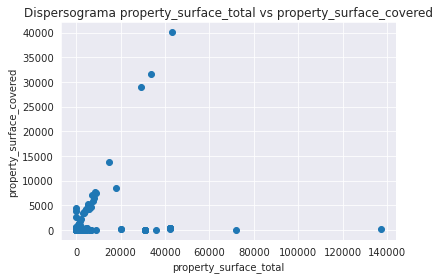

In [259]:
create_scatter_plot(ds_filtrado, 'property_surface_total', 'property_surface_covered')

In [264]:
mahalanobis_surfaces = calculate_mahalanobis_distance(ds_filtrado, 'property_surface_total', 'property_surface_covered')
mahalanobis_surfaces

,property_surface_total,property_surface_covered,mahalanobis
25,171.0,133.0,0.070611
42,58.0,55.0,0.016504
43,70.0,70.0,0.016501
49,104.0,104.0,0.021108
51,73.0,73.0,0.015925
...,...,...,...
460072,130.0,100.0,0.022556
460073,68.0,60.0,0.007525
460074,51.0,30.0,0.031426
460075,37.0,31.0,0.031324


<AxesSubplot:ylabel='mahalanobis'>

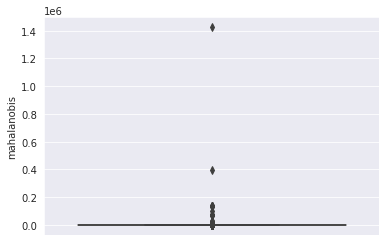

In [266]:
sns.boxplot(y=mahalanobis_surfaces.mahalanobis)

In [267]:
mahalanobis_surfaces.isna().sum()

property_surface_total      0
property_surface_covered    0
mahalanobis                 0
dtype: int64

In [276]:
#Defino umbral
umbral = 10  # elegimos este umbral de varias pruebas hasta llegar a un grafico de dispersion razonable

#Observaciones anómalas
mahalanobis_surfaces[mahalanobis_surfaces['mahalanobis'] > umbral]

,property_surface_total,property_surface_covered,mahalanobis
2352,2032.0,37.0,298.690859
11432,1800.0,280.0,172.742399
15421,777.0,313.0,15.883405
30359,48.0,4435.0,1689.701033
32735,485.0,108.0,10.017585
...,...,...,...
459588,6609.0,60.0,3250.019649
459841,7153.0,7153.0,528.586594
459842,8136.0,6472.0,630.376090
459847,18096.0,8568.0,7585.318543


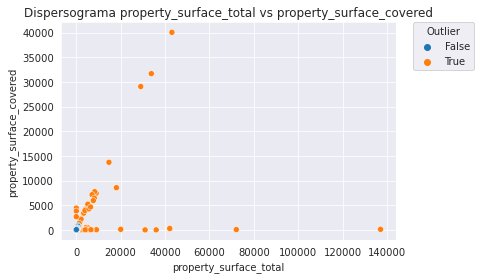

In [277]:
create_scattergram(mahalanobis_surfaces, 'property_surface_total', 'property_surface_covered', umbral)

Analisis entre latitud y logitud de valores atipicos por el metodo de mahalanobis - multivariado

In [281]:
# Arreglar lat/long y dropear nulos antes.
mahalanobis_lat_long_ds = ds_filtrado[(~ds_filtrado.latitud.isna())|(~ds_filtrado.longitud.isna())]
mahalanobis_lat_long = calculate_mahalanobis_distance(mahalanobis_lat_long_ds, 'latitud', 'longitud')
mahalanobis_lat_long

,latitud,longitud,mahalanobis
42,-34.637319,-58.361124,0.116132
43,-34.628647,-58.361871,0.099207
49,-34.610027,-58.401934,0.028533
51,-34.631621,-58.416825,0.048105
53,-34.623886,-58.412746,0.036558
...,...,...,...
460072,-34.603245,-58.489810,0.019620
460073,-34.614063,-58.482814,0.025950
460074,-34.614175,-58.479062,0.023581
460075,-34.614175,-58.479062,0.023581


In [304]:
#Defino umbral
umbral = 9 # elegimos este umbral de varias pruebas hasta llegar a un grafico de dispersion razonable

#Observaciones anómalas
print(f"El mínimo según el umbral es de: {mahalanobis_lat_long[mahalanobis_lat_long['mahalanobis'] > umbral]['mahalanobis'].min()}")
mahalanobis_lat_long[mahalanobis_lat_long['mahalanobis'] > umbral]

El mínimo según el umbral es de: 79.03309689905642


,latitud,longitud,mahalanobis
3088,-31.678900,-63.879640,443.315657
9153,-33.081030,-68.468140,963.222624
9156,-31.390431,-64.179004,512.050957
10486,-41.163826,-71.438923,3209.466697
11432,-33.528049,-64.168459,319.004355
...,...,...,...
424020,-30.436760,-64.317055,690.987104
432801,-31.678900,-63.879640,443.315657
437007,-32.138586,-64.501116,449.543285
448128,-33.081030,-68.468140,963.222624


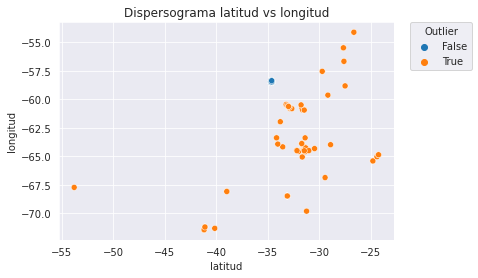

In [305]:
create_scattergram(mahalanobis_lat_long, 'latitud', 'longitud', umbral)


Se puede ver que hay 144 outliers muy marcados cuya distancia de Mahalanobis es mayor a 79. Descartaremos estos casos.

In [308]:
indices = mahalanobis_lat_long[mahalanobis_lat_long['mahalanobis'] > umbral].index
ds_filtrado.drop(indices, inplace = True)

#### LOF

Analisis de outliers con el metodo LOF - Multivariados para ambientes y habitaciones

In [309]:
def create_scores_based_on_training(dataset, col1, col2):
    #Conjunto de entrenamiento
    dataset = dataset[~(dataset[f'{col1}'].isna())]  # que hago con los NAN? Para la preddicion necesito sacarlos.
    dataset = dataset[~(dataset[f'{col2}'].isna())]

    X = dataset[[f'{col1}', f'{col2}']].values

    #Creo el clasificador
    clf = LocalOutlierFactor(n_neighbors=20)

    #Genero prediccion
    y_pred = clf.fit_predict(X)

    #Guardo los scores
    dataset['scores'] = clf.negative_outlier_factor_

    return dataset.copy()

In [310]:
def create_dispersion_diagram(dataset, col1, col2):
    new_lof_ds = dataset.copy()
    new_lof_ds['target'] = 0
    new_col_ds = new_lof_ds
    new_col_ds[[f'{col1}', f'{col2}', 'target']]

    sns.scatterplot(new_col_ds[f'{col1}'], new_col_ds[f'{col2}'], hue=new_col_ds['target'])
    plt.title(f'Diagrama de Dispersión {col1} vs {col2}')
    plt.show()
    return new_lof_ds

In [311]:
def create_lof_graph(dataset, col1, col2):
    #Calculo radio para plotear score
    radius = (dataset.scores.max() - dataset.scores) / (dataset.scores.max() - dataset.scores.min())

    #Grafico LOF
    plt.figure(figsize=(10, 10))
    plt.title("Local Outlier Factor (LOF)")
    plt.scatter(dataset[f'{col1}'].values, dataset[f'{col2}'].values, edgecolor='grey', s=30, label='Datos',
                facecolors='none')
    plt.scatter(dataset[f'{col1}'].values, dataset[f'{col2}'].values, s=1300 * radius, edgecolors='red',
                facecolors='none', label='Outlier scores')
    legend = plt.legend(loc='upper left')
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    plt.show()

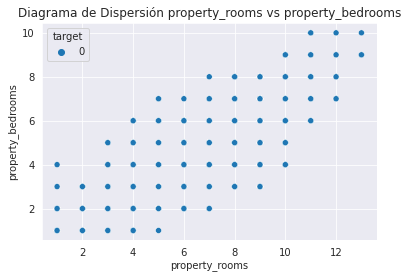

In [312]:
rooms_bedrooms_lof_df = create_dispersion_diagram(ds_filtrado, 'property_rooms', 'property_bedrooms')

In [313]:
new_rooms_bedrooms_lof_df = create_scores_based_on_training(rooms_bedrooms_lof_df, 'property_rooms',
                                                            'property_bedrooms')
new_rooms_bedrooms_lof_df

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,target,scores
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,0,-1.0
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,0,-1.0
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,0,-1.0
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,-34.610027,-58.401934,Once,Venta,Departamento,4.0,2.0,104.0,104.0,146000.0,Venta departamento 4 ambientes Once,0,-1.0
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,-34.631621,-58.416825,Boedo,Venta,PH,4.0,2.0,73.0,73.0,250000.0,PH - Boedo,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460072,v4f5Un9jO7hsD02MWLkKBQ==,2021-01-05,2022-09-02,-34.603245,-58.489810,Villa del Parque,Venta,Departamento,4.0,3.0,130.0,100.0,220000.0,Espectacular 4 amb130m2 con Balcon Terraza!!!,0,-1.0
460073,Aq/Z+XyS8FHbOOxed4xtTw==,2021-01-05,2021-02-17,-34.614063,-58.482814,Villa del Parque,Venta,Departamento,3.0,2.0,68.0,60.0,161000.0,3 ambientes con cochera listo para habitar!,0,-1.0
460074,Rmamz8v4Wkh5xF7PA59Jqw==,2021-01-05,2021-01-27,-34.614175,-58.479062,Villa del Parque,Venta,Departamento,1.0,1.0,51.0,30.0,75500.0,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...,0,-1.0
460075,7yl8Dfx5wobH21YdMU+Kgg==,2021-01-05,2021-01-27,-34.614175,-58.479062,Villa del Parque,Venta,Departamento,1.0,1.0,37.0,31.0,74500.0,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...,0,-1.0


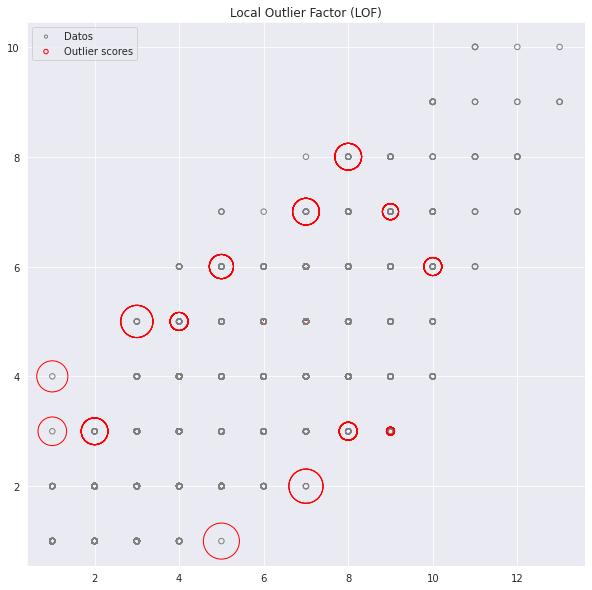

In [314]:
create_lof_graph(new_rooms_bedrooms_lof_df, 'property_rooms', 'property_bedrooms')

Analisis de outliers con el metodo LOF - Multivariados para superficie total y superficie cubierta

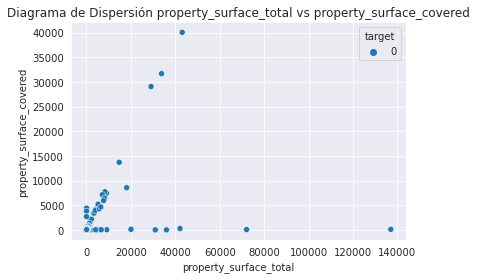

In [315]:
total_covered_lof_df = create_dispersion_diagram(ds_filtrado, 'property_surface_total',
                                                 'property_surface_covered')

In [316]:
new_total_covered_lof_df = create_scores_based_on_training(total_covered_lof_df, 'property_surface_total',
                                                           'property_surface_covered')
new_total_covered_lof_df

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,target,scores
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,0,-1.076764
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,0,-1.000000
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,0,-1.000000
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,-34.610027,-58.401934,Once,Venta,Departamento,4.0,2.0,104.0,104.0,146000.0,Venta departamento 4 ambientes Once,0,-1.000000
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,-34.631621,-58.416825,Boedo,Venta,PH,4.0,2.0,73.0,73.0,250000.0,PH - Boedo,0,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460072,v4f5Un9jO7hsD02MWLkKBQ==,2021-01-05,2022-09-02,-34.603245,-58.489810,Villa del Parque,Venta,Departamento,4.0,3.0,130.0,100.0,220000.0,Espectacular 4 amb130m2 con Balcon Terraza!!!,0,-1.000000
460073,Aq/Z+XyS8FHbOOxed4xtTw==,2021-01-05,2021-02-17,-34.614063,-58.482814,Villa del Parque,Venta,Departamento,3.0,2.0,68.0,60.0,161000.0,3 ambientes con cochera listo para habitar!,0,-1.000000
460074,Rmamz8v4Wkh5xF7PA59Jqw==,2021-01-05,2021-01-27,-34.614175,-58.479062,Villa del Parque,Venta,Departamento,1.0,1.0,51.0,30.0,75500.0,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...,0,-0.997592
460075,7yl8Dfx5wobH21YdMU+Kgg==,2021-01-05,2021-01-27,-34.614175,-58.479062,Villa del Parque,Venta,Departamento,1.0,1.0,37.0,31.0,74500.0,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...,0,-1.000000


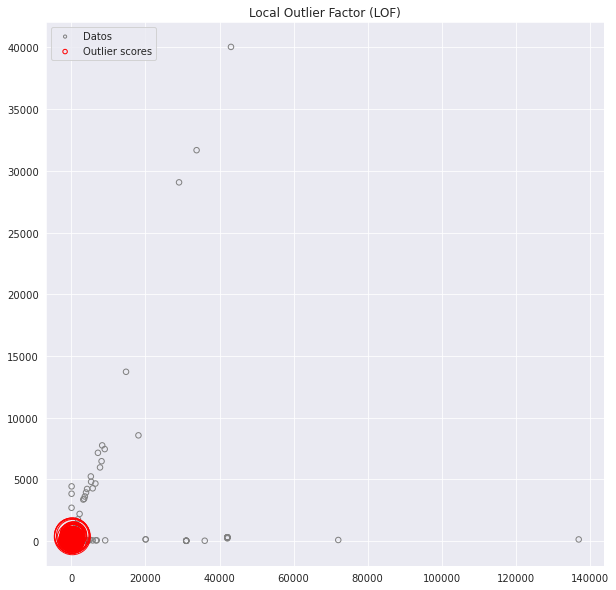

In [317]:
create_lof_graph(new_total_covered_lof_df, 'property_surface_total', 'property_surface_covered')

Analisis de outliers con el metodo LOF - Multivariados para latitud y longitud

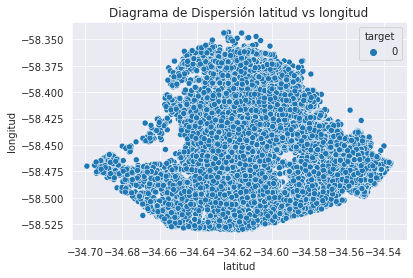

In [318]:
latitud_longitud_df = create_dispersion_diagram(ds_filtrado, 'latitud', 'longitud')

In [319]:
new_latitud_longitud_df = create_scores_based_on_training(latitud_longitud_df, 'latitud', 'longitud')
new_latitud_longitud_df

,id,start_date,end_date,latitud,longitud,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,target,scores
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,0,-0.974913
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,0,-0.978615
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,-34.610027,-58.401934,Once,Venta,Departamento,4.0,2.0,104.0,104.0,146000.0,Venta departamento 4 ambientes Once,0,-0.992715
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,-34.631621,-58.416825,Boedo,Venta,PH,4.0,2.0,73.0,73.0,250000.0,PH - Boedo,0,-1.148365
53,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,2022-01-27,-34.623886,-58.412746,Boedo,Venta,PH,2.0,1.0,61.0,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,0,-1.118710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460072,v4f5Un9jO7hsD02MWLkKBQ==,2021-01-05,2022-09-02,-34.603245,-58.489810,Villa del Parque,Venta,Departamento,4.0,3.0,130.0,100.0,220000.0,Espectacular 4 amb130m2 con Balcon Terraza!!!,0,-1.082414
460073,Aq/Z+XyS8FHbOOxed4xtTw==,2021-01-05,2021-02-17,-34.614063,-58.482814,Villa del Parque,Venta,Departamento,3.0,2.0,68.0,60.0,161000.0,3 ambientes con cochera listo para habitar!,0,-1.034948
460074,Rmamz8v4Wkh5xF7PA59Jqw==,2021-01-05,2021-01-27,-34.614175,-58.479062,Villa del Parque,Venta,Departamento,1.0,1.0,51.0,30.0,75500.0,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...,0,-0.997527
460075,7yl8Dfx5wobH21YdMU+Kgg==,2021-01-05,2021-01-27,-34.614175,-58.479062,Villa del Parque,Venta,Departamento,1.0,1.0,37.0,31.0,74500.0,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...,0,-0.997527


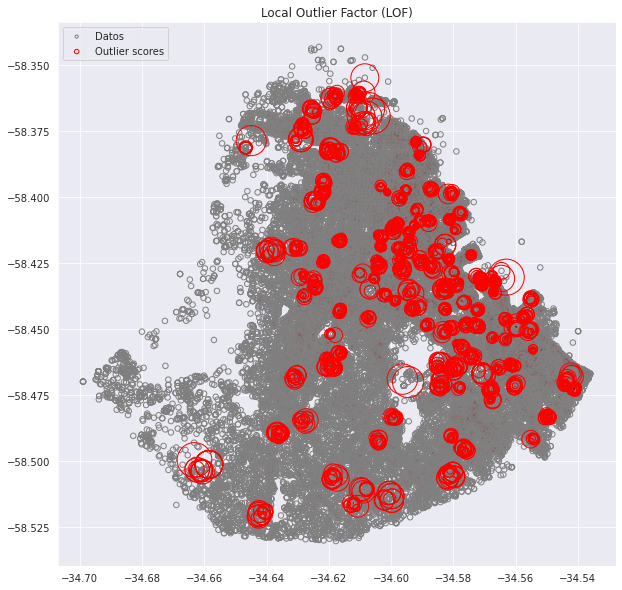

In [320]:
create_lof_graph(new_latitud_longitud_df, 'latitud', 'longitud')

#### Isolation Forest

Analisis de outliers con el metodo de Isolation Forest - Multivariados para ambientes y habitaciones

In [321]:
rooms_bedrooms_iforest = ds_filtrado[['property_rooms', 'property_bedrooms']]
rooms_bedrooms_iforest = rooms_bedrooms_iforest[~(rooms_bedrooms_iforest['property_rooms'].isna())]
rooms_bedrooms_iforest = rooms_bedrooms_iforest[~(rooms_bedrooms_iforest['property_bedrooms'].isna())]

iforest = IsolationForest(n_estimators=100, max_samples='auto',
                          contamination=0.05, max_features=2,
                          bootstrap=False, n_jobs=-1, random_state=1)

pred = iforest.fit_predict(rooms_bedrooms_iforest)
#Almaceno scores y etiquetas
rooms_bedrooms_iforest['scores'] = iforest.decision_function(rooms_bedrooms_iforest)
rooms_bedrooms_iforest['outlier_label'] = pred

#Observaciones anómalas
rooms_bedrooms_iforest[rooms_bedrooms_iforest.outlier_label == -1]

,property_rooms,property_bedrooms,scores,outlier_label
659,6.0,4.0,-0.012506,-1
713,7.0,4.0,-0.065706,-1
816,7.0,4.0,-0.065706,-1
834,9.0,4.0,-0.119328,-1
1040,8.0,6.0,-0.161177,-1
...,...,...,...,...
459789,7.0,3.0,-0.083672,-1
459813,6.0,5.0,-0.085427,-1
459839,4.0,4.0,-0.000884,-1
459868,5.0,2.0,-0.027364,-1


In [322]:
rooms_bedrooms_iforest.outlier_label.value_counts()

 1    89062
-1     3757
Name: outlier_label, dtype: int64

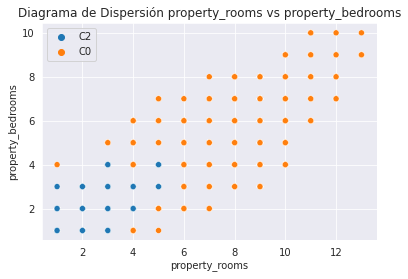

In [323]:
#Grafico dispersograma
color = [f"C{n + 1}" for n in (rooms_bedrooms_iforest['outlier_label'].values)]

sns.scatterplot(rooms_bedrooms_iforest['property_rooms'], rooms_bedrooms_iforest['property_bedrooms'], hue=color)
plt.title('Diagrama de Dispersión property_rooms vs property_bedrooms')
plt.show()

In [324]:
#Selecciono el árbol
estimator = iforest.estimators_[5]

#Grafico
plt.figure(figsize=(10,10))
sk.tree.plot_tree(estimator,feature_names = rooms_bedrooms_iforest.feature_names, filled=True, max_depth=1)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'feature_names'

<Figure size 720x720 with 0 Axes>

Analisis de outliers con el metodo de Isolation Forest - Multivariados para superficie total y superficie cubierta

In [ ]:
total_covered_iforest = ds_filtrado[['property_surface_total', 'property_surface_covered']]
total_covered_iforest = total_covered_iforest[~(total_covered_iforest['property_surface_total'].isna())]
total_covered_iforest = total_covered_iforest[~(total_covered_iforest['property_surface_covered'].isna())]

iforest = IsolationForest(n_estimators=100, max_samples='auto',
                          contamination=0.05, max_features=2,
                          bootstrap=False, n_jobs=-1, random_state=1)

pred = iforest.fit_predict(total_covered_iforest)
#Almaceno scores y etiquetas
total_covered_iforest['scores'] = iforest.decision_function(total_covered_iforest)
total_covered_iforest['outlier_label'] = pred

#Observaciones anómalas
total_covered_iforest[total_covered_iforest.outlier_label == -1]

In [ ]:
total_covered_iforest.outlier_label.value_counts()

In [ ]:
#Grafico dispersograma
color = [f"C{n + 1}" for n in (total_covered_iforest['outlier_label'].values)]

sns.scatterplot(total_covered_iforest['property_surface_total'], total_covered_iforest['property_surface_covered'],
                hue=color)
plt.title('Diagrama de Dispersión property_surface_total vs property_surface_covered')
plt.show()

In [ ]:
#Selecciono el árbol
#estimator = iforest.estimators_[5]

#Grafico
#plt.figure(figsize=(10,10))
#sk.tree.plot_tree(estimator,feature_names = total_covered_iforest.feature_names, filled=True, max_depth=1)
#plt.show()

Analisis de outliers con el metodo de Isolation Forest - Multivariados para latitud y longitud

In [ ]:
latitud_longitud_iforest = ds_filtrado[['latitud', 'longitud']]
latitud_longitud_iforest = latitud_longitud_iforest[~(latitud_longitud_iforest['latitud'].isna())]
latitud_longitud_iforest = latitud_longitud_iforest[~(latitud_longitud_iforest['longitud'].isna())]

iforest = IsolationForest(n_estimators=100, max_samples='auto',
                          contamination=0.05, max_features=2,
                          bootstrap=False, n_jobs=-1, random_state=1)

pred = iforest.fit_predict(latitud_longitud_iforest)
#Almaceno scores y etiquetas
latitud_longitud_iforest['scores'] = iforest.decision_function(latitud_longitud_iforest)
latitud_longitud_iforest['outlier_label'] = pred

#Observaciones anómalas
latitud_longitud_iforest[latitud_longitud_iforest.outlier_label == -1]

In [ ]:
latitud_longitud_iforest.outlier_label.value_counts()

In [ ]:
#Grafico dispersograma
color = [f"C{n + 1}" for n in (latitud_longitud_iforest['outlier_label'].values)]

sns.scatterplot(latitud_longitud_iforest['latitud'], latitud_longitud_iforest['longitud'], hue=color)
plt.title('Diagrama de Dispersión latitud vs longitud')
plt.show()

In [ ]:
#Selecciono el árbol
#estimator = iforest.estimators_[5]

#Grafico
#plt.figure(figsize=(10,10))
#sk.tree.plot_tree(estimator,feature_names = latitud_longitud_iforest.feature_names, filled=True, max_depth=1)
#plt.show()

### Analisis para eliminacion de outliers

##### Ambientes

Compararemos los outliers IQR vs Z-Score

In [ ]:
pd.Index([1,2,3])

In [ ]:
def compare_outliers(iqr, z_score_ds, zm_score_ds, z_column_name, zm_column_name):
    print("Comparación IQR - Zscore - Zscore Modificado")
    print(f"largo de outlier iqr: {len(iqr)}")
    z_score = z_score_ds[(z_score_ds[z_column_name] > 3) | (z_score_ds[z_column_name] < -3)]
    print(f"largo de outlier z: {len(z_score)}")
    outlier_sup_zm = zm_score_ds[(zm_score_ds[zm_column_name] > 3.5) | (zm_score_ds[zm_column_name] < -3.5)]
    print(f"largo de outlier zm: {len(outlier_sup_zm)}")
    df_iqr_z = pd.merge(iqr, z_score, on='id')
    df_intersection = pd.merge(df_iqr_z, outlier_sup_zm, on='id')
    print(
        f"Suma total de outliers para metodo IQR + Zscore + Zscore Modificado: {len(iqr) + len(z_score) + len(outlier_sup_zm)}")
    print(
        f"Los outliers compartidos son: {len(df_intersection)}. Constituyen al {(len(df_intersection) * 100) // len(ds_filtrado)}% de los datos")


def current_univariate_outliers(dataset,iqr_ds,z_score_ds,zm_score_ds):
  """Filtra los outliers de cada metodo teniendo en cuenta el dataset actual"""
  current_iqr_outliers=iqr_ds.merge(dataset,left_index=True,right_index=True)
  updated_iqr_ds=iqr_ds.loc[current_iqr_outliers.index]

  current_zscore_outliers=z_score_ds.merge(dataset,left_index=True,right_index=True)
  updated_z_bedrooms_ds=z_score_ds.loc[current_zscore_outliers.index]

  current_zmscore_outliers=zm_score_ds.merge(dataset,left_index=True,right_index=True)
  updated_zm_bedrooms_ds=zm_score_ds.loc[current_zmscore_outliers.index]

  return updated_iqr_ds,updated_z_bedrooms_ds,updated_zm_bedrooms_ds

In [ ]:
compare_outliers(outlier_sup_rooms_iqr, z_rooms_ds, zm_rooms_ds, 'z_property_rooms', 'zm_property_rooms')

Los outliers de Zscore modificado están presentes en los otros 2 métodos, mientras que, tanto iqr como zscore comparten los mismos outliers. Procederemos a eliminar los 732.

In [ ]:
ds_filtrado.drop(outlier_sup_rooms_iqr.index, inplace=True)
print(f"Se eliminaron {len(outlier_sup_rooms_iqr)} registros")

##### Habitaciones

In [ ]:
outlier_sup_bedrooms_iqr,z_bedrooms_ds,zm_bedrooms_ds = current_univariate_outliers(ds_filtrado,outlier_sup_bedrooms_iqr,z_bedrooms_ds,zm_bedrooms_ds)

compare_outliers(outlier_sup_bedrooms_iqr, z_bedrooms_ds, zm_bedrooms_ds,"z_property_bedrooms", 'zm_property_bedrooms')

Nuevamente como podemos observar, estos valores atipicos fueron detectados por los 3 métodos, por lo que procederemos a eliminar las 34 observaciones.

In [ ]:
ds_filtrado.drop(outlier_sup_bedrooms_iqr.index, inplace=True)
print(f"Se eliminaron {len(outlier_sup_bedrooms_iqr)} registros")

##### Superficie Total

Como indicamos anteriormente, optaremos por eliminar los registros que presenten una superficie total mayor a 500. Pero primero corroboraremos que los outliers sean identificados por los 3 métodos

In [ ]:
outlier_sup_total_500,z_total_ds,zm_total_ds = current_univariate_outliers(ds_filtrado,outlier_sup_total_500,z_total_ds,zm_total_ds)

compare_outliers(outlier_sup_total_500, z_total_ds, zm_total_ds, "z_property_surface_total", "zm_property_surface_total")

Como vemos que fueron identificados procedemos a borrarlos.

In [ ]:
ds_filtrado.drop(outlier_sup_total_500.index, inplace=True)
print(f"Se eliminaron {len(outlier_sup_total_500)} registros")

##### Superficie Cubierta

In [ ]:
outliers_surface_covered_iqr = ds_filtrado[ds_filtrado.property_surface_covered > 500]

Como podemos ver, luego de haber borrado los outliers de superficie total reducimos notablemente la cantidad de outliers que se encontraban en superficie cubierta en el rango que habiamos decidido borrar. Vemos si los restantes son detectados por los métodos

In [ ]:
outliers_surface_covered_iqr,z_covered_ds,zm_covered_ds = current_univariate_outliers(ds_filtrado,outliers_surface_covered_iqr,z_covered_ds,zm_covered_ds)

compare_outliers(outliers_surface_covered_iqr, z_covered_ds, zm_covered_ds, "z_property_surface_covered", "zm_property_surface_covered")

In [ ]:
ds_filtrado.drop(outliers_surface_covered_iqr.index, inplace=True)
print(f"Se eliminaron {len(outliers_surface_covered_iqr)} registros")